In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from google.colab import drive
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Reshape, Dropout, BatchNormalization, MaxPooling1D
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import shap

In [4]:
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/MyDrive/TCC/RMS INDEPENDENTES.xlsx', sheet_name='JEITO 7')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Processamento dos Dados

In [5]:
#df_tratado = df.iloc[:, 0:8]
df_tratado = df.iloc[:, 1:8]
df_rms = df.iloc[:, 0]

In [6]:
print(df_tratado)
print(df_rms)

            IRI    V      k     c      ms    mus     kus
0      1.722854   30  14000  1876  186.75   41.5  200000
1      1.530687   30  14000  1876  186.75   41.5  200000
2      1.559335   30  14000  1876  186.75   41.5  200000
3      1.575025   30  14000  1876  186.75   41.5  200000
4      1.690348   30  14000  1876  186.75   41.5  200000
...         ...  ...    ...   ...     ...    ...     ...
48595  2.776620  120  31000  2301  275.00  100.0  200000
48596  2.713946  120  31000  2301  275.00  100.0  200000
48597  1.971269  120  31000  2301  275.00  100.0  200000
48598  3.323964  120  31000  2301  275.00  100.0  200000
48599  1.667053  120  31000  2301  275.00  100.0  200000

[48600 rows x 7 columns]
0        0.374902
1        0.312542
2        0.299262
3        0.326102
4        0.425370
           ...   
48595    1.494772
48596    1.484513
48597    2.118282
48598    1.756251
48599    1.522003
Name: RMS, Length: 48600, dtype: float64


In [7]:
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_tratado)

In [8]:
nome_coluna = df_rms.name

# Aplicando a transformação no array numpy
array_rms = df_rms.values.reshape(-1, 1)
array_rms_scaled = scaler.fit_transform(array_rms)

# Criando um novo DataFrame pandas mantendo o nome da coluna original
df_rms = pd.DataFrame(array_rms_scaled, columns=[nome_coluna])

In [9]:
ultimas_linhas = df_norm[-54:]

df_ultimas = pd.DataFrame(ultimas_linhas)

df_ultimas.to_excel('ultimas_54_linhas.xlsx', index=False)

df_norm = df_norm[:-54]

df_rms = df_rms.iloc[:-54]

In [10]:
print(df_norm)
print(df_rms)

[[0.17507015 0.         0.         ... 0.         0.         0.        ]
 [0.14772091 0.         0.         ... 0.         0.         0.        ]
 [0.1517981  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.02863182 1.         0.12230216 ... 0.32806691 1.         0.        ]
 [0.05614373 1.         0.12230216 ... 0.32806691 1.         0.        ]
 [0.03237512 1.         0.12230216 ... 0.32806691 1.         0.        ]]
            RMS
0      0.045682
1      0.036110
2      0.034071
3      0.038191
4      0.053429
...         ...
48541  0.035823
48542  0.027140
48543  0.042561
48544  0.040122
48545  0.047997

[48546 rows x 1 columns]


In [11]:
df_norm = pd.DataFrame(df_norm, columns=df.columns[1:8])

df_norm['VEICULO'] = df.reset_index(drop=True)['VEICULO']

#nome_coluna = df_rms.name

df_norm.insert(0, nome_coluna, df_rms)

In [12]:
print(df_norm)

            RMS       IRI    V         k         c        ms  mus  kus  \
0      0.045682  0.175070  0.0  0.000000  0.000000  0.000000  0.0  0.0   
1      0.036110  0.147721  0.0  0.000000  0.000000  0.000000  0.0  0.0   
2      0.034071  0.151798  0.0  0.000000  0.000000  0.000000  0.0  0.0   
3      0.038191  0.154031  0.0  0.000000  0.000000  0.000000  0.0  0.0   
4      0.053429  0.170444  0.0  0.000000  0.000000  0.000000  0.0  0.0   
...         ...       ...  ...       ...       ...       ...  ...  ...   
48541  0.035823  0.023412  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48542  0.027140  0.021601  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48543  0.042561  0.028632  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48544  0.040122  0.056144  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48545  0.047997  0.032375  1.0  0.122302  0.128283  0.328067  1.0  0.0   

            VEICULO  
0              A-HB  
1              A-HB  
2              A-HB  
3              A-HB  
4

In [13]:
grupos = df_norm.groupby('VEICULO')

df_A_HB = grupos.get_group('A-HB').iloc[:, 0:8] if 'A-HB' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_B_HB = grupos.get_group('B-HB').iloc[:, 0:8] if 'B-HB' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_C_HB = grupos.get_group('C-HB').iloc[:, 0:8] if 'C-HB' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_D_SDN = grupos.get_group('D-SDN').iloc[:, 0:8] if 'D-SDN' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_F_SDN = grupos.get_group('F-SDN').iloc[:, 0:8] if 'F-SDN' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_D_SUV = grupos.get_group('D-SUV').iloc[:, 0:8] if 'D-SUV' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_B_SPORTS = grupos.get_group('B-SPORTS').iloc[:, 0:8] if 'B-SPORTS' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_STOCKCAR = grupos.get_group('STOCKCAR').iloc[:, 0:8] if 'STOCKCAR' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])
df_EUROPEAN_VAN = grupos.get_group('EUROPEAN VAN').iloc[:, 0:8] if 'EUROPEAN VAN' in grupos.groups else pd.DataFrame(columns=df.columns[0:9])

In [68]:
print(df_B_HB)

            RMS       IRI    V         k        c        ms       mus  \
540    0.042827  0.175070  0.0  0.096245  0.41195  0.318408  0.306587   
541    0.034344  0.147721  0.0  0.096245  0.41195  0.318408  0.306587   
542    0.033955  0.151798  0.0  0.096245  0.41195  0.318408  0.306587   
543    0.035082  0.154031  0.0  0.096245  0.41195  0.318408  0.306587   
544    0.048365  0.170444  0.0  0.096245  0.41195  0.318408  0.306587   
...         ...       ...  ...       ...      ...       ...       ...   
44815  0.247789  0.325042  1.0  0.096245  0.41195  0.318408  0.306587   
44816  0.247022  0.316123  1.0  0.096245  0.41195  0.318408  0.306587   
44817  0.341767  0.210425  1.0  0.096245  0.41195  0.318408  0.306587   
44818  0.288468  0.402940  1.0  0.096245  0.41195  0.318408  0.306587   
44819  0.231975  0.167129  1.0  0.096245  0.41195  0.318408  0.306587   

            kus  
540    0.566038  
541    0.566038  
542    0.566038  
543    0.566038  
544    0.566038  
...         ...

In [14]:
X = df_norm.iloc[:, 1:8]
#y = df_norm.iloc[:, 0]
#y = df.iloc[:-54, 0]
y = df_rms

In [15]:
print(df_norm)

            RMS       IRI    V         k         c        ms  mus  kus  \
0      0.045682  0.175070  0.0  0.000000  0.000000  0.000000  0.0  0.0   
1      0.036110  0.147721  0.0  0.000000  0.000000  0.000000  0.0  0.0   
2      0.034071  0.151798  0.0  0.000000  0.000000  0.000000  0.0  0.0   
3      0.038191  0.154031  0.0  0.000000  0.000000  0.000000  0.0  0.0   
4      0.053429  0.170444  0.0  0.000000  0.000000  0.000000  0.0  0.0   
...         ...       ...  ...       ...       ...       ...  ...  ...   
48541  0.035823  0.023412  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48542  0.027140  0.021601  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48543  0.042561  0.028632  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48544  0.040122  0.056144  1.0  0.122302  0.128283  0.328067  1.0  0.0   
48545  0.047997  0.032375  1.0  0.122302  0.128283  0.328067  1.0  0.0   

            VEICULO  
0              A-HB  
1              A-HB  
2              A-HB  
3              A-HB  
4

In [71]:
print(X)
print(y)

            IRI    V        k         c        ms       mus       kus
0      0.175070  0.0  0.02221  0.103632  0.121332  0.123328  0.377358
1      0.147721  0.0  0.02221  0.103632  0.121332  0.123328  0.377358
2      0.151798  0.0  0.02221  0.103632  0.121332  0.123328  0.377358
3      0.154031  0.0  0.02221  0.103632  0.121332  0.123328  0.377358
4      0.170444  0.0  0.02221  0.103632  0.121332  0.123328  0.377358
...         ...  ...      ...       ...       ...       ...       ...
48595  0.325042  1.0  0.11211  0.181862  0.312453  0.702823  0.377358
48596  0.316123  1.0  0.11211  0.181862  0.312453  0.702823  0.377358
48597  0.210425  1.0  0.11211  0.181862  0.312453  0.702823  0.377358
48598  0.402940  1.0  0.11211  0.181862  0.312453  0.702823  0.377358
48599  0.167129  1.0  0.11211  0.181862  0.312453  0.702823  0.377358

[48600 rows x 7 columns]
            RMS
0      0.045682
1      0.036110
2      0.034071
3      0.038191
4      0.053429
...         ...
48595  0.217583
48596 

#Modelo Conv1D com normalização

In [17]:
modelo = Sequential([
    Conv1D(filters=8, kernel_size=8, input_shape=(X.shape[1], 1), activation='relu', padding='same'),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(units=1, activation='relu')

])

modelo.compile(optimizer='adam', loss='mean_squared_error')

modelo.fit(X, y, epochs=50, batch_size=32, verbose=1)

y_pred = modelo.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'R^2 Score: {r2:.3f}')

Epoch 1/50
1518/1518 [==============================] - 8s 4ms/step - loss: 0.0025
Epoch 2/50
1518/1518 [==============================] - 6s 4ms/step - loss: 0.0015
Epoch 3/50
1518/1518 [==============================] - 5s 3ms/step - loss: 0.0015
Epoch 4/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 5/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 6/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 7/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 8/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 9/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 10/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 11/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 12/50
1518/1518 [==============================] - 3s 2ms/step - loss: 0.0014
E

# Gráfico Geral

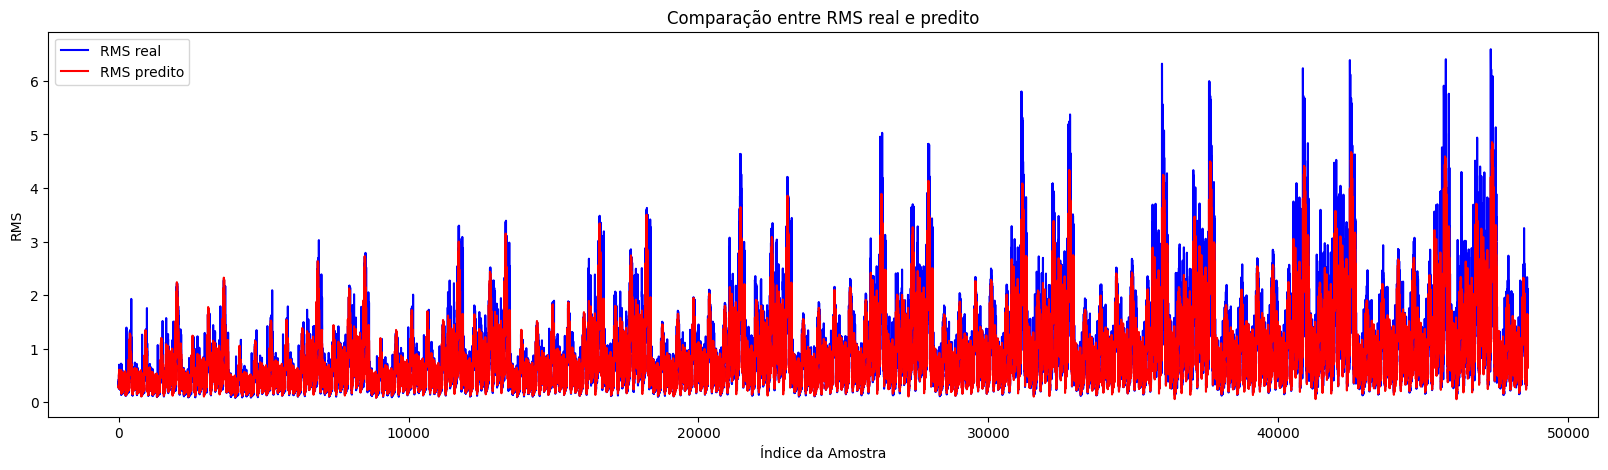

In [212]:
plt.figure(figsize=(20, 5))

plt.plot(range(len(y)), y, label='RMS real', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='RMS predito', color='red')
plt.legend()
plt.xlabel('Índice da Amostra')
plt.ylabel('RMS')
plt.title('Comparação entre RMS real e predito')
plt.show()

#A-HB

In [ ]:
print(df_A_HB)

In [ ]:
y_A_HB = df_A_HB.iloc[:, 0]

X_A_HB = df_A_HB.iloc[:, 1:8]

y_pred_A_HB = modelo.predict(X_A_HB)

In [ ]:
print(X_A_HB)

## Variações K

### -10%

In [ ]:
X_A_HB_k_menos_10 = X_A_HB.copy()

X_A_HB_k_menos_10['k'] = 0.014806

In [ ]:
print(X_A_HB_k_menos_10)

In [ ]:
y_pred_A_HB_k_menos_10 = modelo.predict(X_A_HB_k_menos_10)

In [ ]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    #plt.plot(range(inicio, fim), y_pred_A_HB_k_menos_10[inicio:fim], label='RMS k alterado em menos 10%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')


### -20%

In [220]:
X_A_HB_k_menos_20 = X_A_HB.copy()

X_A_HB_k_menos_20['k'] = 0.007403

In [221]:
print(X_A_HB_k_menos_20)

            IRI    V         k         c        ms       mus       kus
0      0.175070  0.0  0.007403  0.103632  0.121332  0.123328  0.377358
1      0.147721  0.0  0.007403  0.103632  0.121332  0.123328  0.377358
2      0.151798  0.0  0.007403  0.103632  0.121332  0.123328  0.377358
3      0.154031  0.0  0.007403  0.103632  0.121332  0.123328  0.377358
4      0.170444  0.0  0.007403  0.103632  0.121332  0.123328  0.377358
...         ...  ...       ...       ...       ...       ...       ...
44275  0.325042  1.0  0.007403  0.103632  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.007403  0.103632  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.007403  0.103632  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.007403  0.103632  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.007403  0.103632  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [222]:
y_pred_A_HB_k_menos_20 = modelo.predict(X_A_HB_k_menos_20)

169/169 [==============================] - 0s 1ms/step


In [223]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_k_menos_20[inicio:fim], label='RMS k alterado em menos 20%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')


Output hidden; open in https://colab.research.google.com to view.

### -30%

In [224]:
X_A_HB_k_menos_30 = X_A_HB.copy()

X_A_HB_k_menos_30['k'] = 0

In [225]:
print(X_A_HB_k_menos_30)

            IRI    V  k         c        ms       mus       kus
0      0.175070  0.0  0  0.103632  0.121332  0.123328  0.377358
1      0.147721  0.0  0  0.103632  0.121332  0.123328  0.377358
2      0.151798  0.0  0  0.103632  0.121332  0.123328  0.377358
3      0.154031  0.0  0  0.103632  0.121332  0.123328  0.377358
4      0.170444  0.0  0  0.103632  0.121332  0.123328  0.377358
...         ...  ... ..       ...       ...       ...       ...
44275  0.325042  1.0  0  0.103632  0.121332  0.123328  0.377358
44276  0.316123  1.0  0  0.103632  0.121332  0.123328  0.377358
44277  0.210425  1.0  0  0.103632  0.121332  0.123328  0.377358
44278  0.402940  1.0  0  0.103632  0.121332  0.123328  0.377358
44279  0.167129  1.0  0  0.103632  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [226]:
y_pred_A_HB_k_menos_30 = modelo.predict(X_A_HB_k_menos_30)

169/169 [==============================] - 0s 1ms/step


In [227]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_k_menos_30[inicio:fim], label='RMS k alterado em menos 30%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')


Output hidden; open in https://colab.research.google.com to view.

### +10%

In [228]:
X_A_HB_k_mais_10 = X_A_HB.copy()

X_A_HB_k_mais_10['k'] = 0.029613

In [229]:
print(X_A_HB_k_mais_10)

            IRI    V         k         c        ms       mus       kus
0      0.175070  0.0  0.029613  0.103632  0.121332  0.123328  0.377358
1      0.147721  0.0  0.029613  0.103632  0.121332  0.123328  0.377358
2      0.151798  0.0  0.029613  0.103632  0.121332  0.123328  0.377358
3      0.154031  0.0  0.029613  0.103632  0.121332  0.123328  0.377358
4      0.170444  0.0  0.029613  0.103632  0.121332  0.123328  0.377358
...         ...  ...       ...       ...       ...       ...       ...
44275  0.325042  1.0  0.029613  0.103632  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.029613  0.103632  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.029613  0.103632  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.029613  0.103632  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.029613  0.103632  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [230]:
y_pred_A_HB_k_mais_10 = modelo.predict(X_A_HB_k_mais_10)

169/169 [==============================] - 0s 2ms/step


In [233]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_k_mais_10[inicio:fim], label='RMS k alterado em mais 10%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

### +20%

In [234]:
X_A_HB_k_mais_20 = X_A_HB.copy()

X_A_HB_k_mais_20['k'] = 0.037017

In [235]:
print(X_A_HB_k_mais_20)

            IRI    V         k         c        ms       mus       kus
0      0.175070  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
1      0.147721  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
2      0.151798  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
3      0.154031  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
4      0.170444  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
...         ...  ...       ...       ...       ...       ...       ...
44275  0.325042  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.037017  0.103632  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [236]:
y_pred_A_HB_k_mais_20 = modelo.predict(X_A_HB_k_mais_20)

169/169 [==============================] - 0s 3ms/step


In [237]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_k_mais_20[inicio:fim], label='RMS k alterado em mais 20%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

### +30%

In [238]:
X_A_HB_k_mais_30 = X_A_HB.copy()

X_A_HB_k_mais_30['k'] = 0.037017

In [239]:
print(X_A_HB_k_mais_30)

            IRI    V         k         c        ms       mus       kus
0      0.175070  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
1      0.147721  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
2      0.151798  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
3      0.154031  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
4      0.170444  0.0  0.037017  0.103632  0.121332  0.123328  0.377358
...         ...  ...       ...       ...       ...       ...       ...
44275  0.325042  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.037017  0.103632  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.037017  0.103632  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [240]:
y_pred_A_HB_k_mais_30 = modelo.predict(X_A_HB_k_mais_30)

169/169 [==============================] - 0s 2ms/step


In [241]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_k_mais_30[inicio:fim], label='RMS k alterado em mais 30%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

## Variações c

### -10%

In [125]:
X_A_HB_c_menos_10 = X_A_HB.copy()

X_A_HB_c_menos_10['c'] = 0.069026

In [126]:
print(X_A_HB_c_menos_10)

            IRI    V        k         c        ms       mus       kus
0      0.175070  0.0  0.02221  0.069026  0.121332  0.123328  0.377358
1      0.147721  0.0  0.02221  0.069026  0.121332  0.123328  0.377358
2      0.151798  0.0  0.02221  0.069026  0.121332  0.123328  0.377358
3      0.154031  0.0  0.02221  0.069026  0.121332  0.123328  0.377358
4      0.170444  0.0  0.02221  0.069026  0.121332  0.123328  0.377358
...         ...  ...      ...       ...       ...       ...       ...
44275  0.325042  1.0  0.02221  0.069026  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.02221  0.069026  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.02221  0.069026  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.02221  0.069026  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.02221  0.069026  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [127]:
y_pred_A_HB_c_menos_10 = modelo.predict(X_A_HB_c_menos_10)

169/169 [==============================] - 0s 2ms/step


In [136]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_c_menos_10[inicio:fim], label='RMS c alterado em menos 10%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

### -20%

In [242]:
X_A_HB_c_menos_20 = X_A_HB.copy()

X_A_HB_c_menos_20['c'] = 0.034568

In [243]:
print(X_A_HB_c_menos_20)

            IRI    V        k         c        ms       mus       kus
0      0.175070  0.0  0.02221  0.034568  0.121332  0.123328  0.377358
1      0.147721  0.0  0.02221  0.034568  0.121332  0.123328  0.377358
2      0.151798  0.0  0.02221  0.034568  0.121332  0.123328  0.377358
3      0.154031  0.0  0.02221  0.034568  0.121332  0.123328  0.377358
4      0.170444  0.0  0.02221  0.034568  0.121332  0.123328  0.377358
...         ...  ...      ...       ...       ...       ...       ...
44275  0.325042  1.0  0.02221  0.034568  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.02221  0.034568  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.02221  0.034568  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.02221  0.034568  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.02221  0.034568  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [246]:
y_pred_A_HB_c_menos_20 = modelo.predict(X_A_HB_c_menos_20)

169/169 [==============================] - 0s 2ms/step


In [248]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_c_menos_20[inicio:fim], label='RMS c alterado em menos 20%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

### -30%

In [249]:
X_A_HB_c_menos_30 = X_A_HB.copy()

X_A_HB_c_menos_30['c'] = 0

In [250]:
print(X_A_HB_c_menos_30)

            IRI    V        k  c        ms       mus       kus
0      0.175070  0.0  0.02221  0  0.121332  0.123328  0.377358
1      0.147721  0.0  0.02221  0  0.121332  0.123328  0.377358
2      0.151798  0.0  0.02221  0  0.121332  0.123328  0.377358
3      0.154031  0.0  0.02221  0  0.121332  0.123328  0.377358
4      0.170444  0.0  0.02221  0  0.121332  0.123328  0.377358
...         ...  ...      ... ..       ...       ...       ...
44275  0.325042  1.0  0.02221  0  0.121332  0.123328  0.377358
44276  0.316123  1.0  0.02221  0  0.121332  0.123328  0.377358
44277  0.210425  1.0  0.02221  0  0.121332  0.123328  0.377358
44278  0.402940  1.0  0.02221  0  0.121332  0.123328  0.377358
44279  0.167129  1.0  0.02221  0  0.121332  0.123328  0.377358

[5400 rows x 7 columns]


In [251]:
y_pred_A_HB_c_menos_30 = modelo.predict(X_A_HB_c_menos_30)

169/169 [==============================] - 1s 3ms/step


In [252]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.plot(range(inicio, fim), y_pred_A_HB_c_menos_30[inicio:fim], label='RMS c alterado em menos 30%', color='red')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

## Grafico todos os veiculos

### A-HB

In [18]:
y_A_HB = df_A_HB.iloc[:, 0]

X_A_HB = df_A_HB.iloc[:, 1:8]

y_pred_A_HB = modelo.predict(X_A_HB)

169/169 [==============================] - 1s 6ms/step


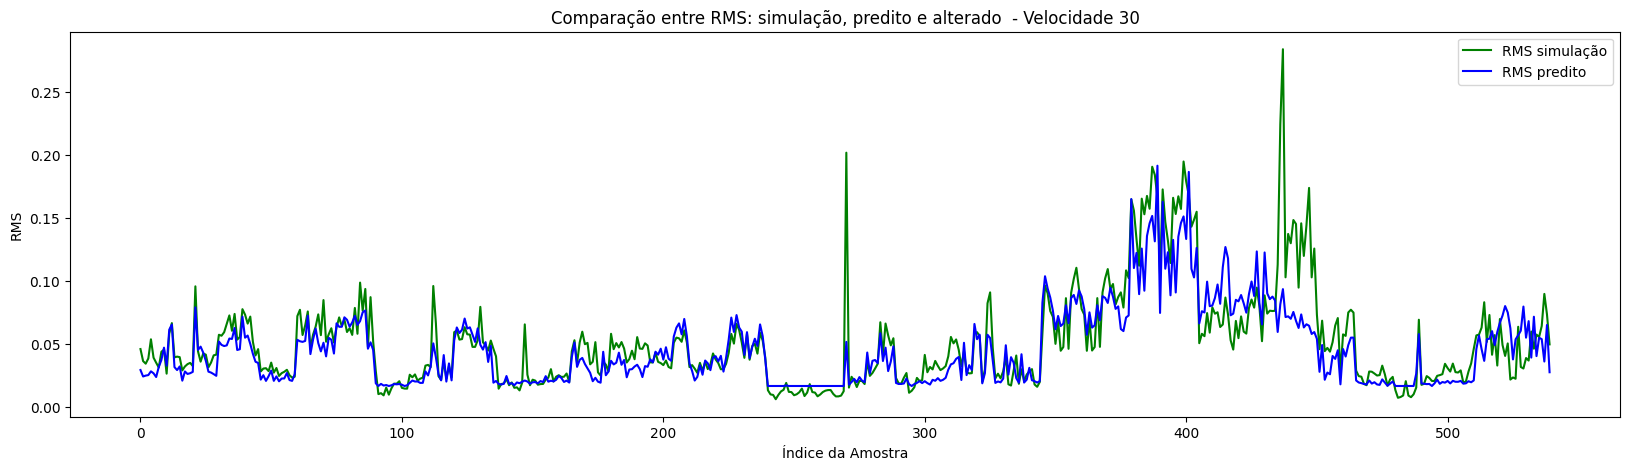

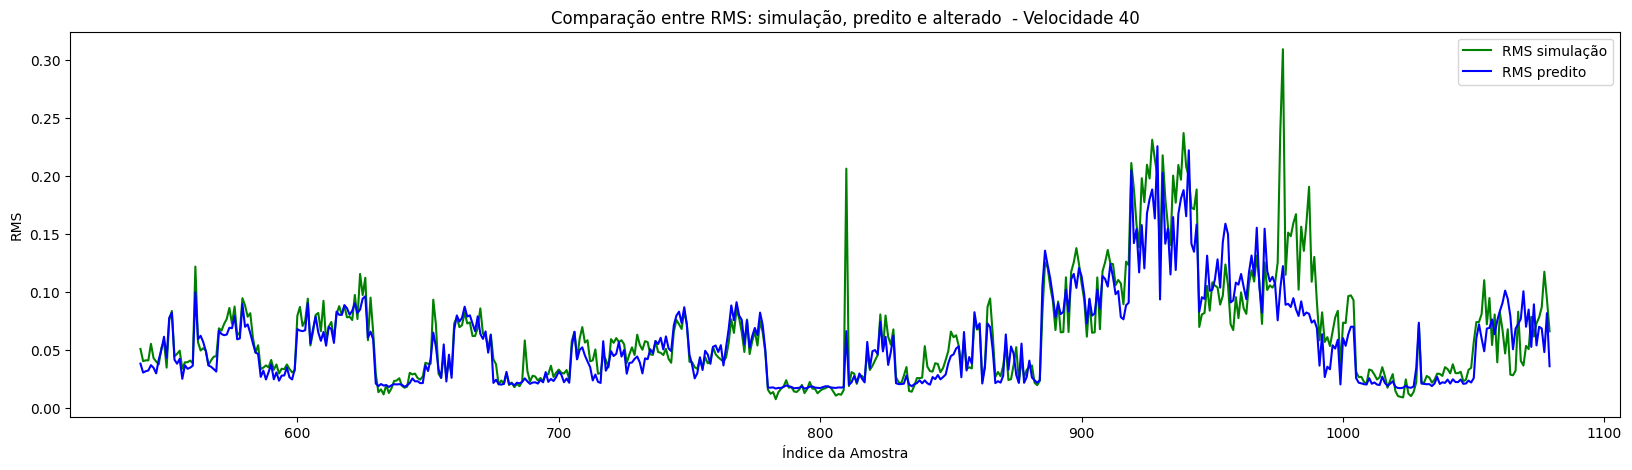

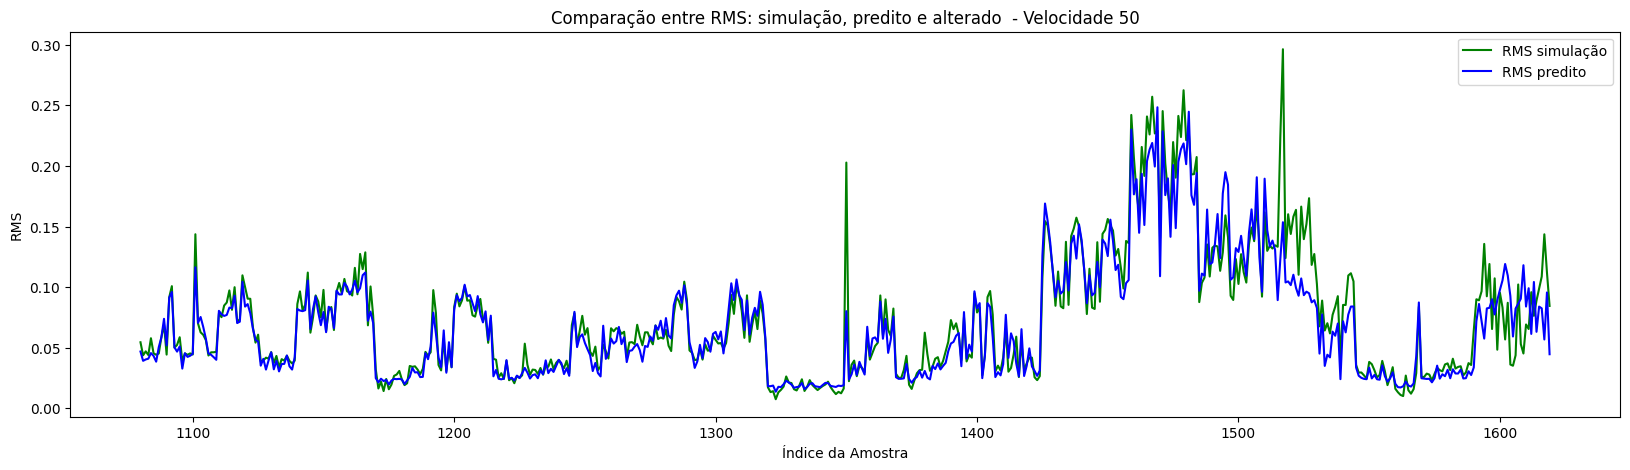

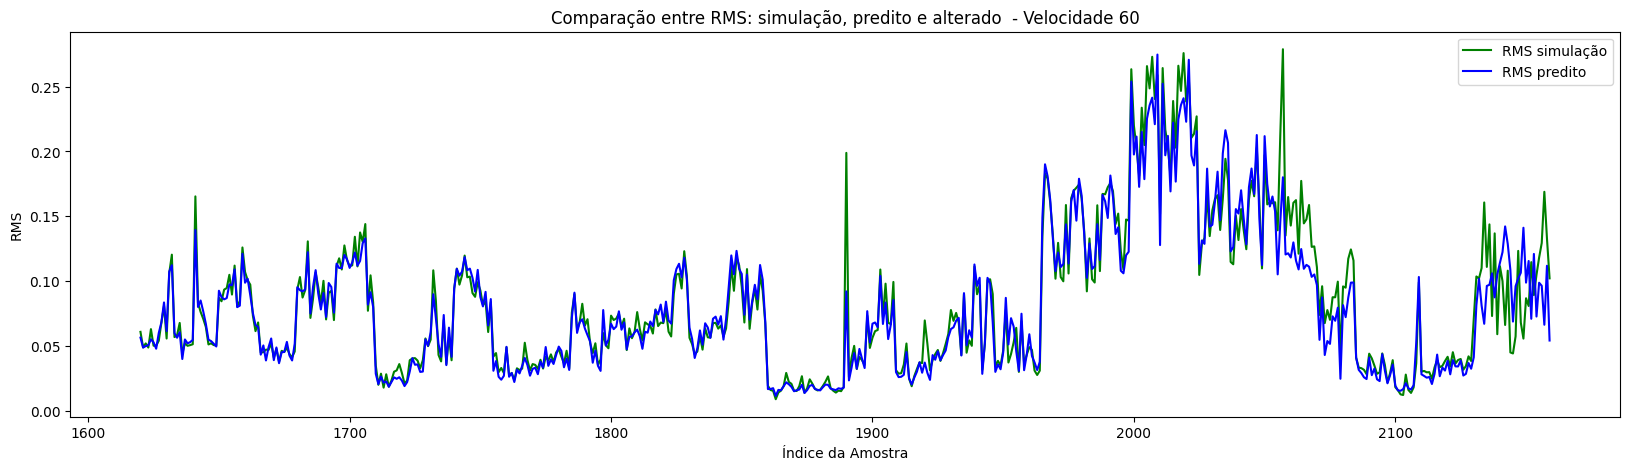

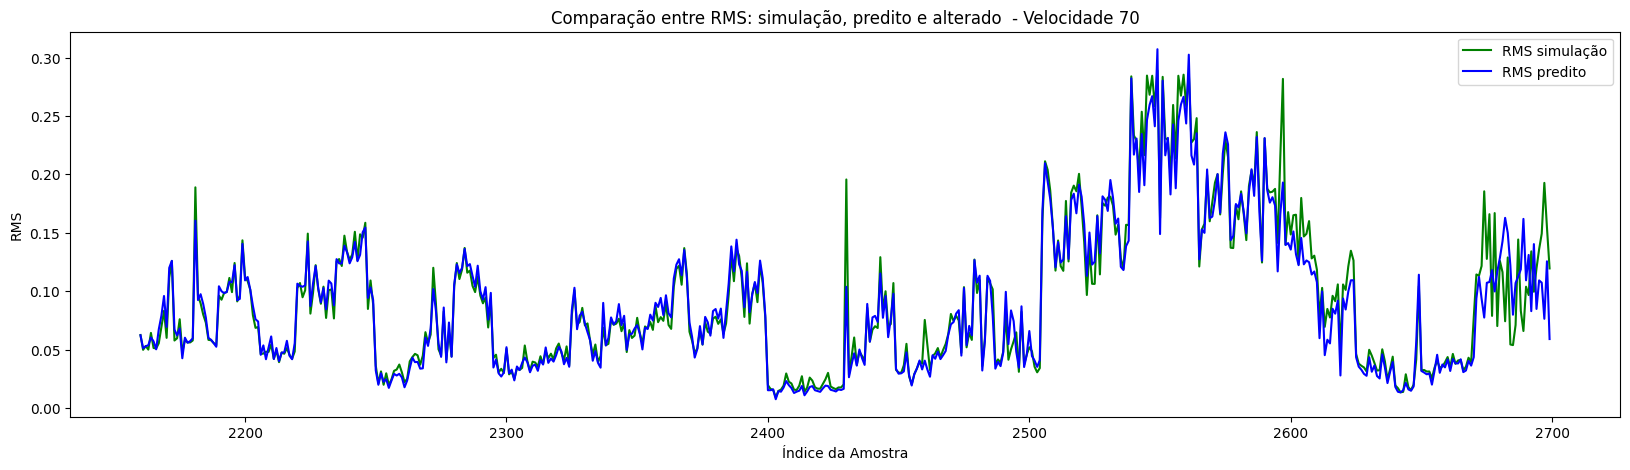

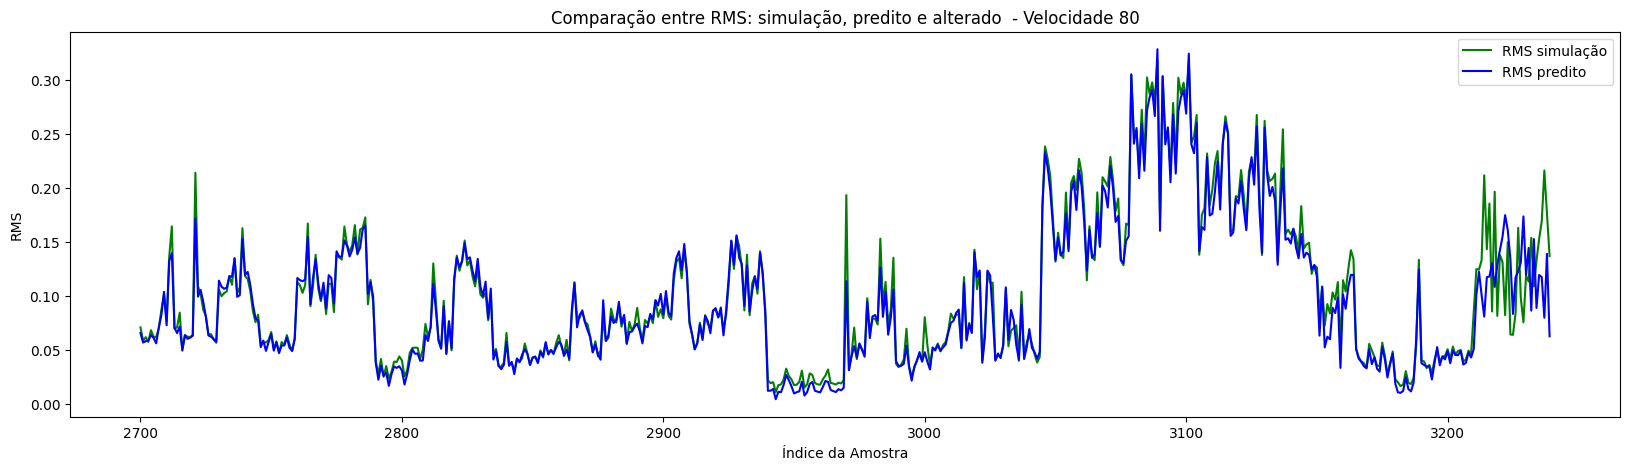

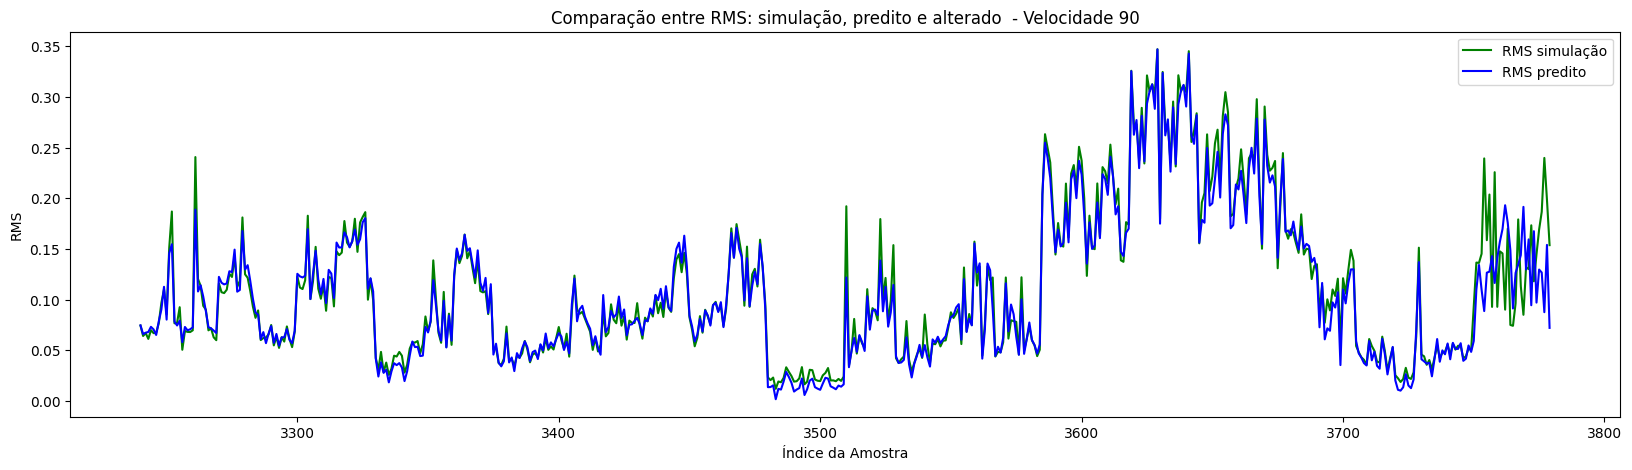

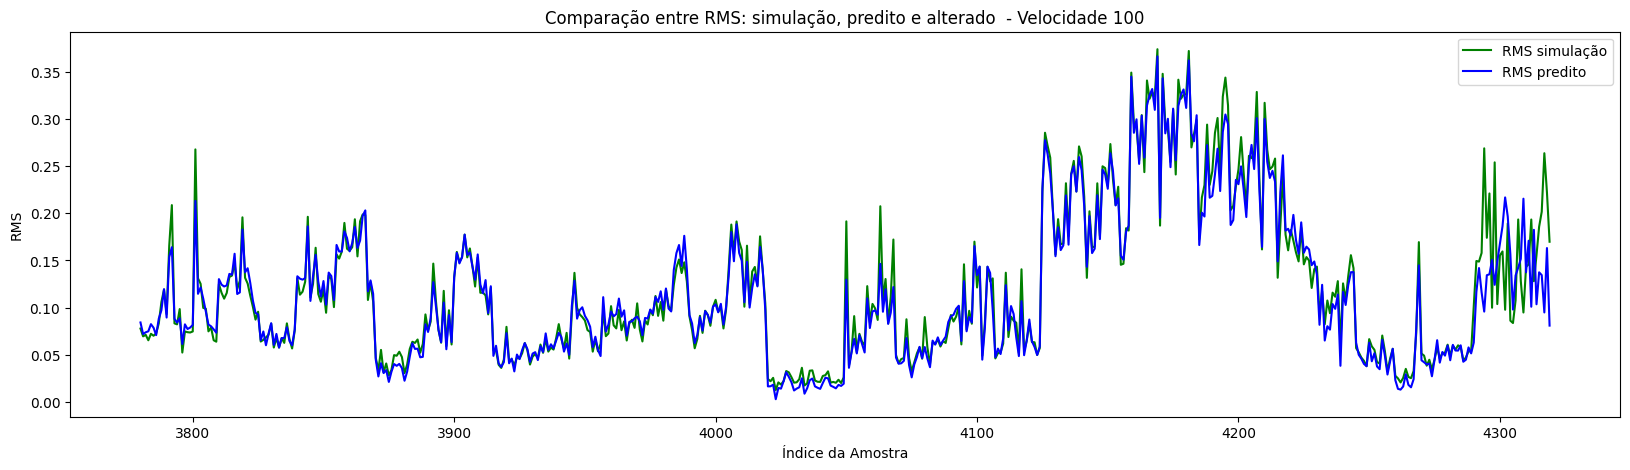

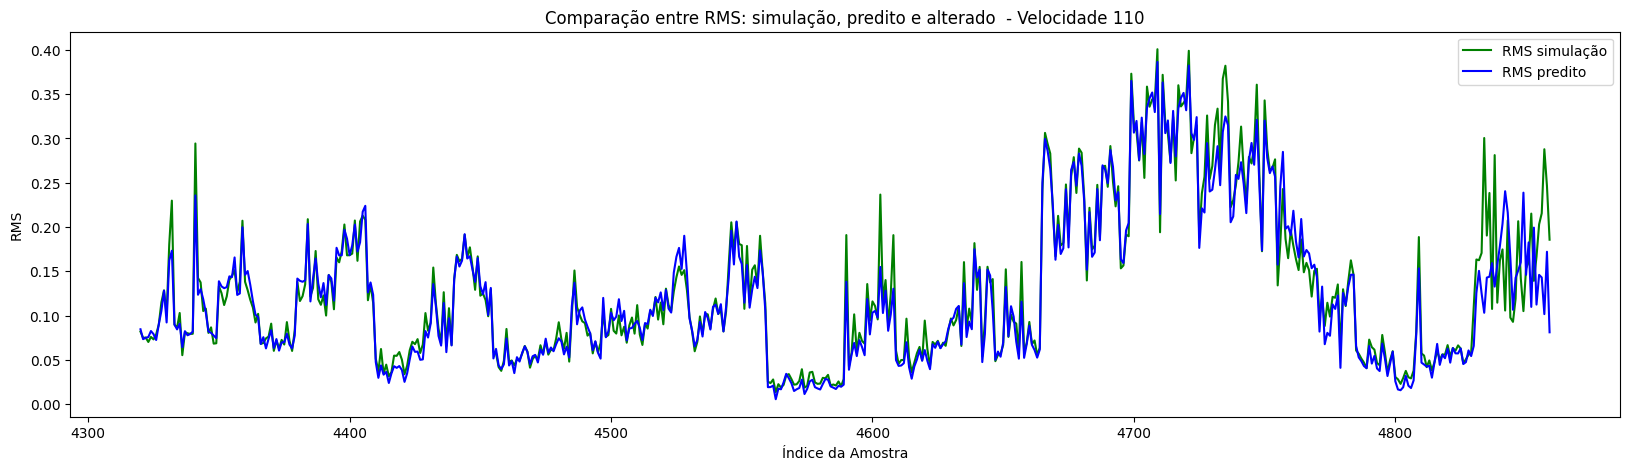

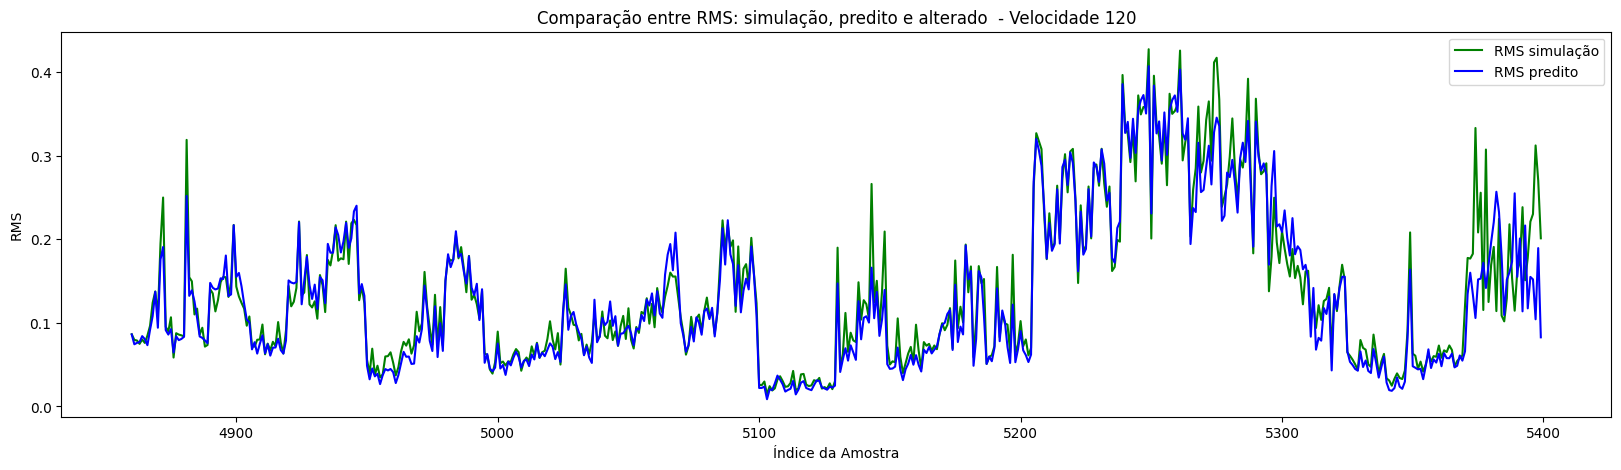

In [19]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_A_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_A_HB[inicio:fim], label='RMS predito', color='blue')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

### B-HB

In [96]:
y_B_HB = df_B_HB.iloc[:, 0]

X_B_HB = df_B_HB.iloc[:, 1:8]

y_pred_B_HB = modelo.predict(X_B_HB)

169/169 [==============================] - 0s 3ms/step


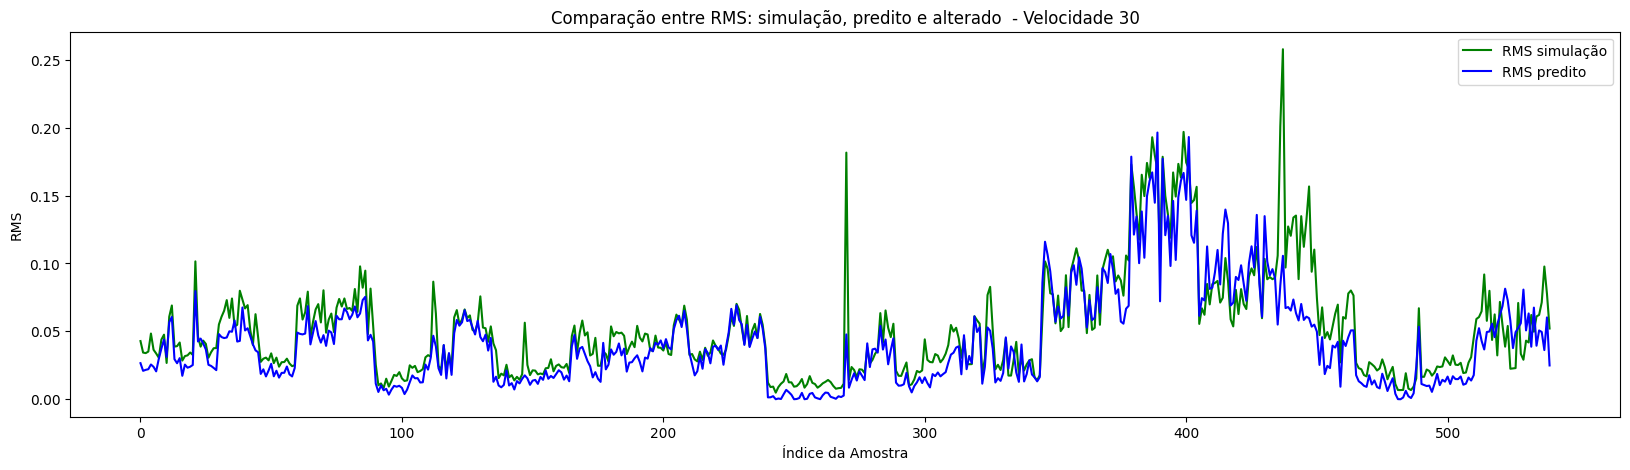

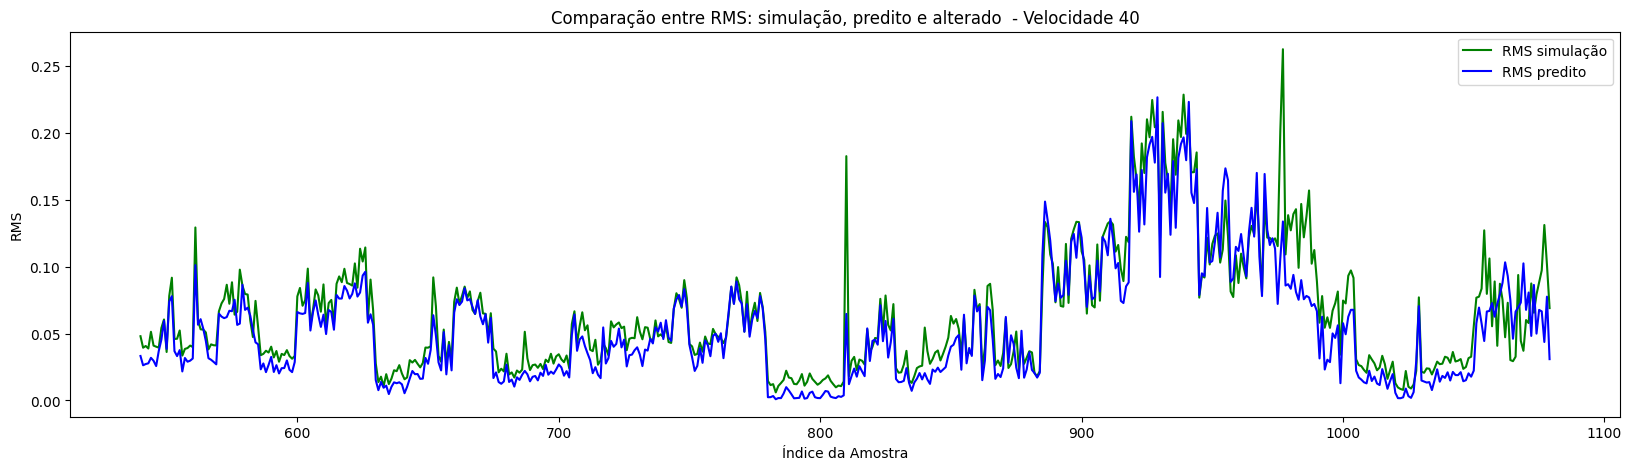

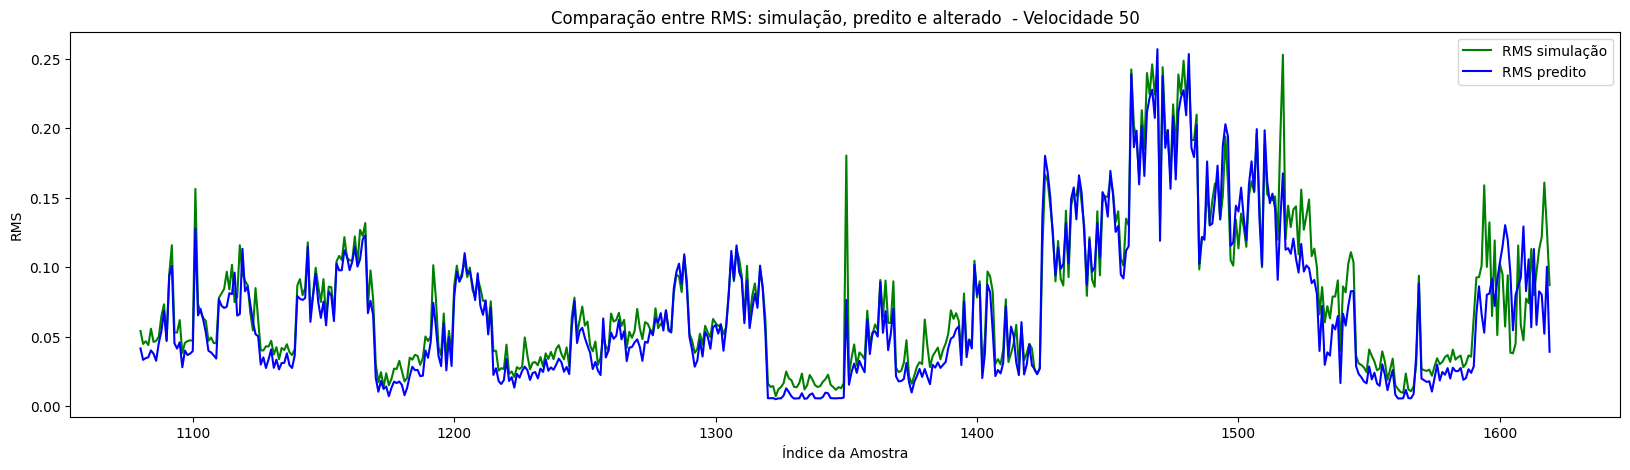

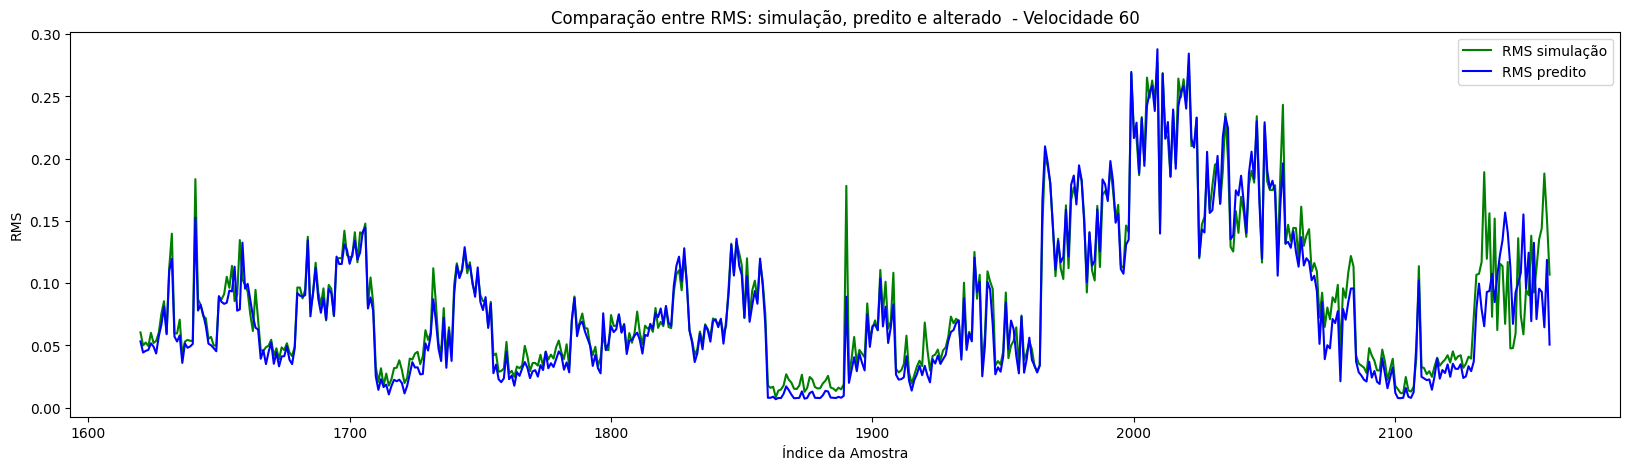

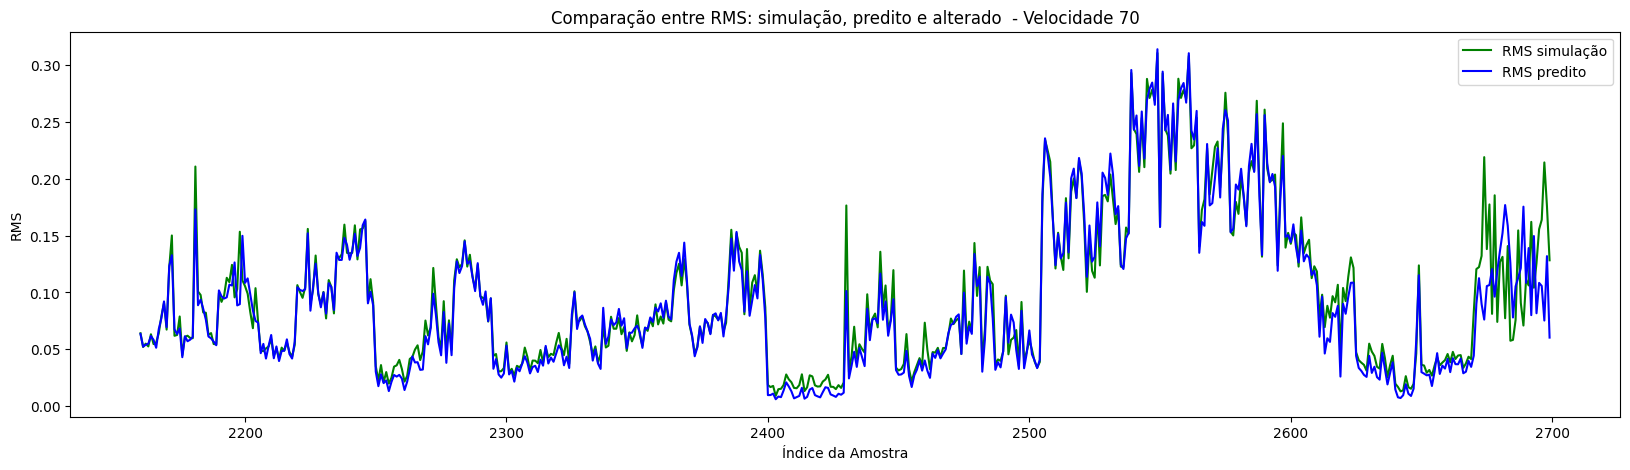

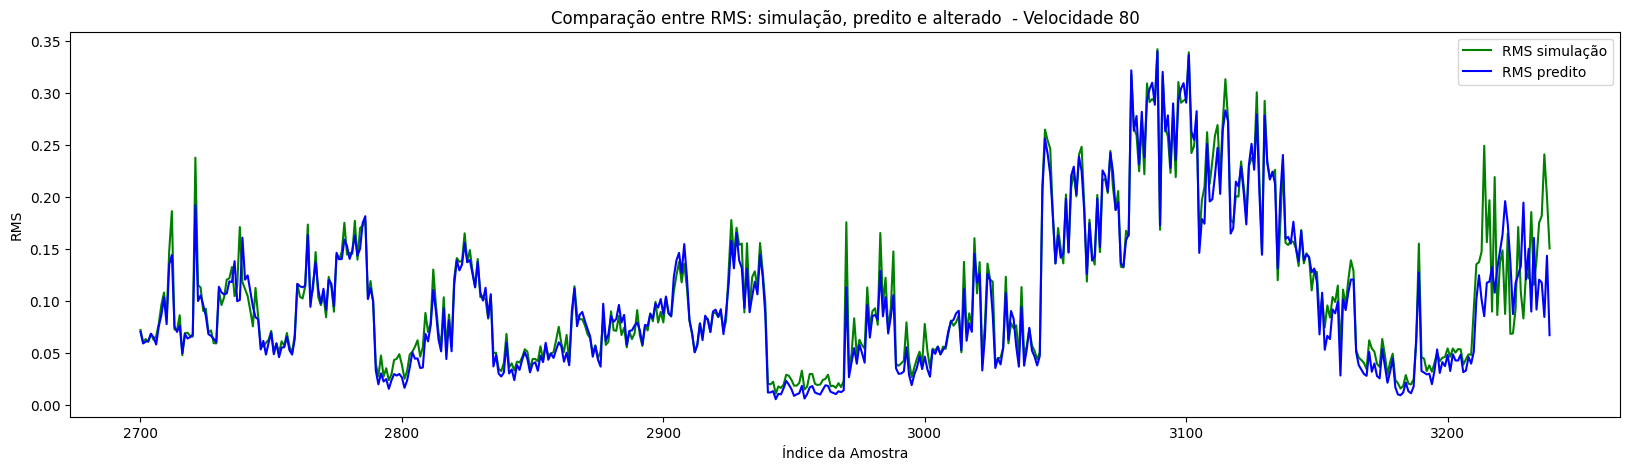

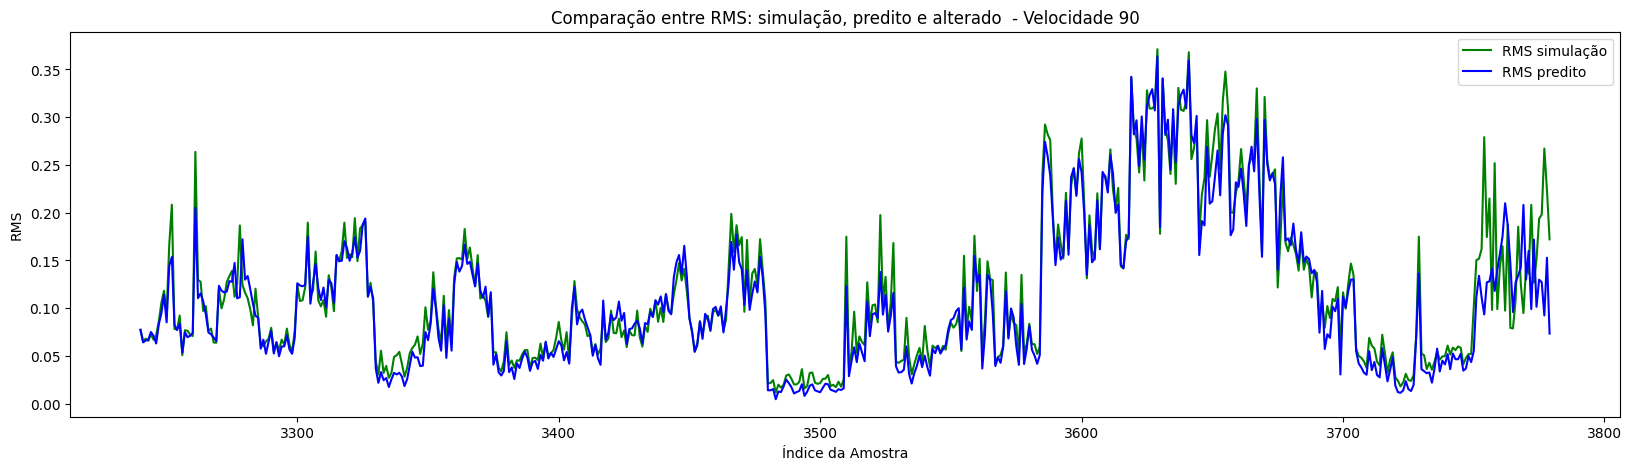

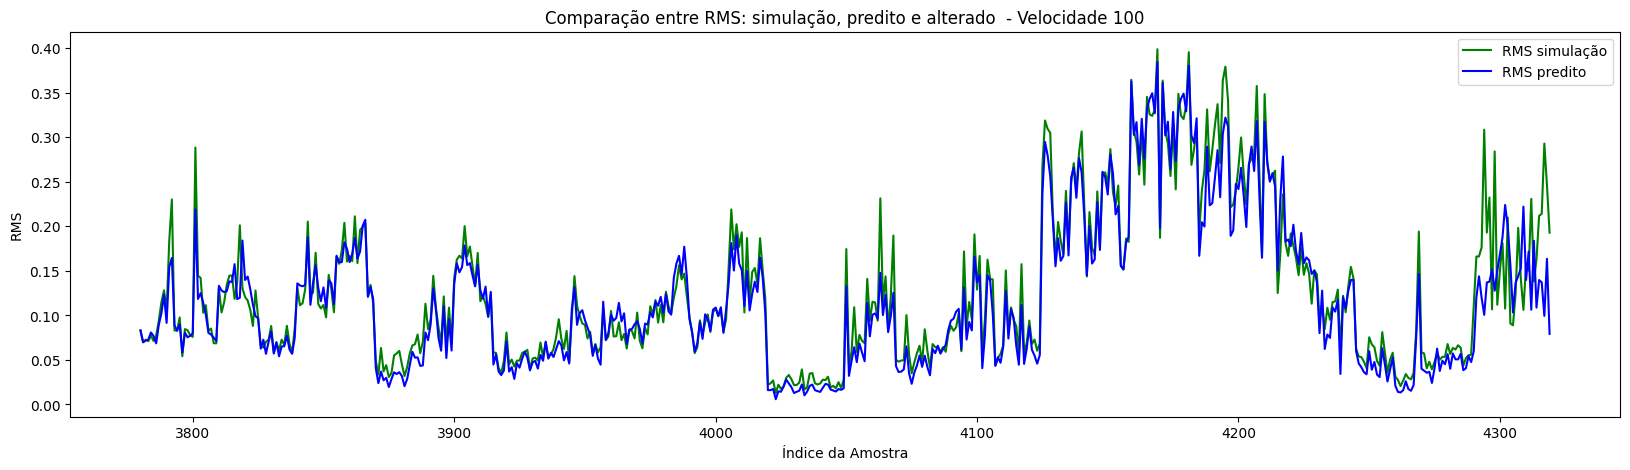

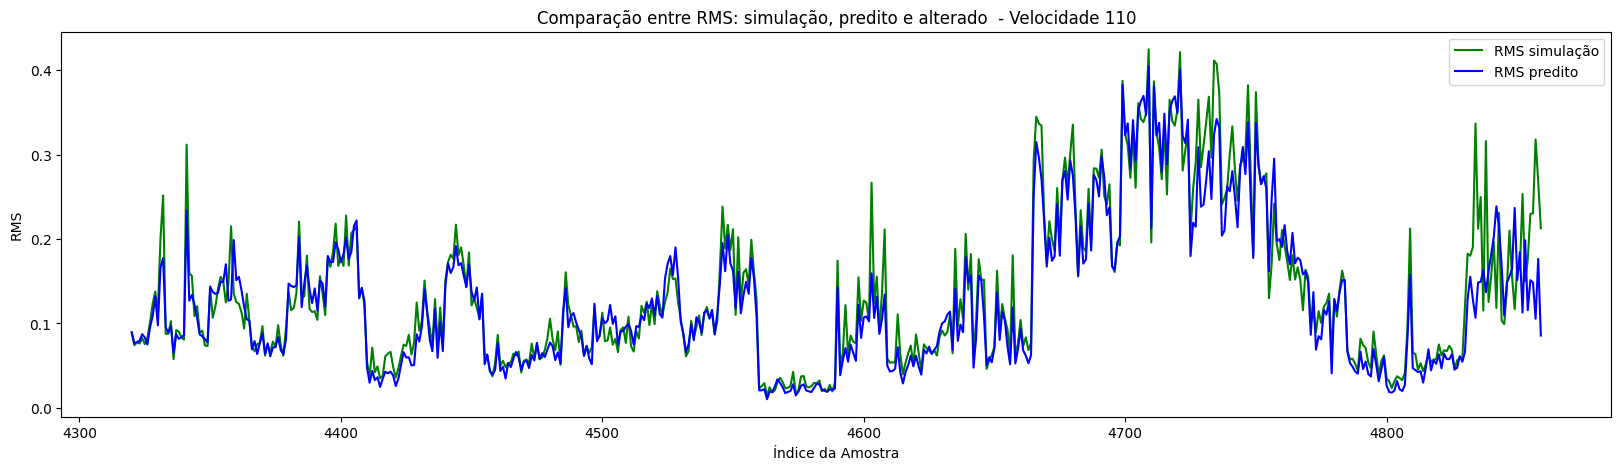

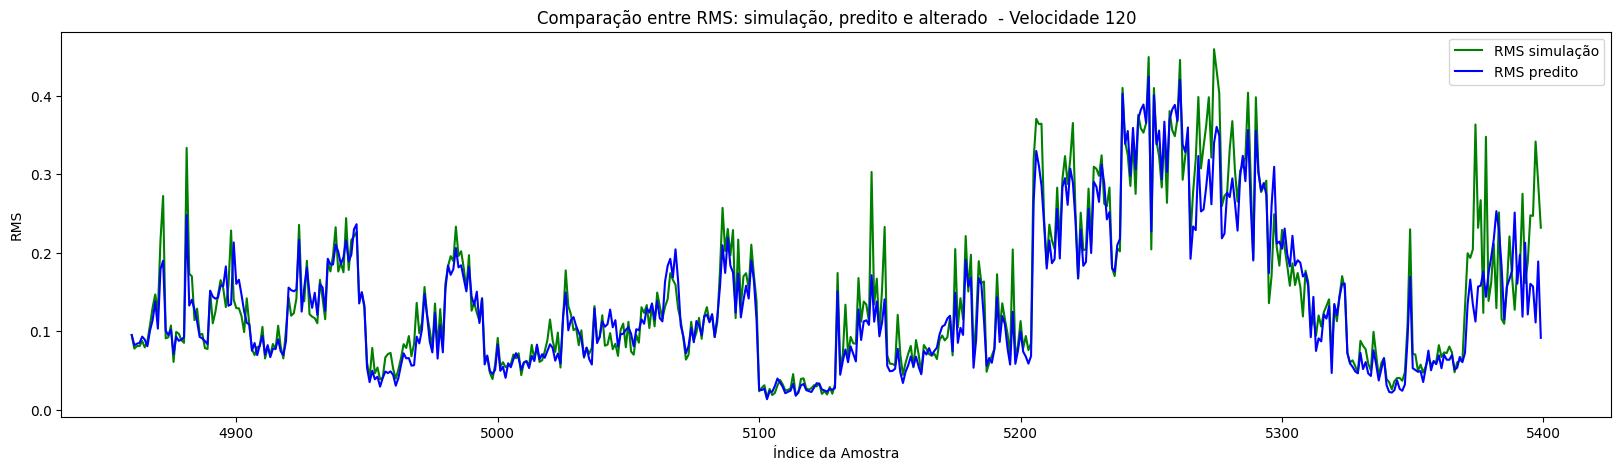

In [97]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_B_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_B_HB[inicio:fim], label='RMS predito', color='blue')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

### C-HB

In [98]:
y_C_HB = df_C_HB.iloc[:, 0]

X_C_HB = df_C_HB.iloc[:, 1:8]

y_pred_C_HB = modelo.predict(X_C_HB)

169/169 [==============================] - 0s 2ms/step


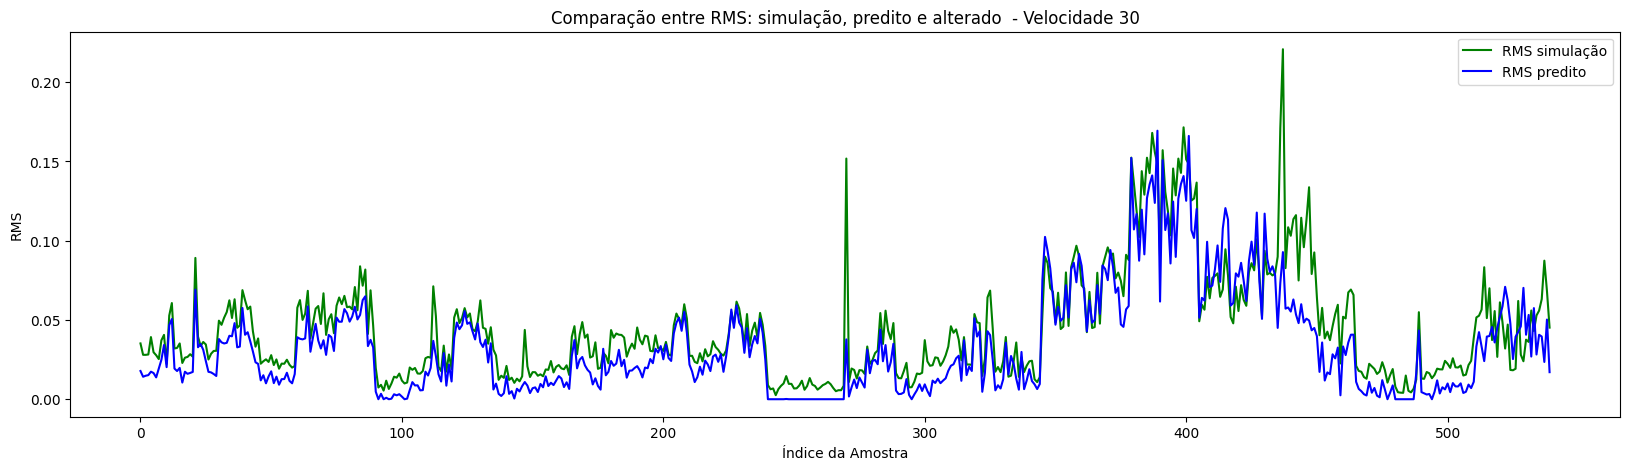

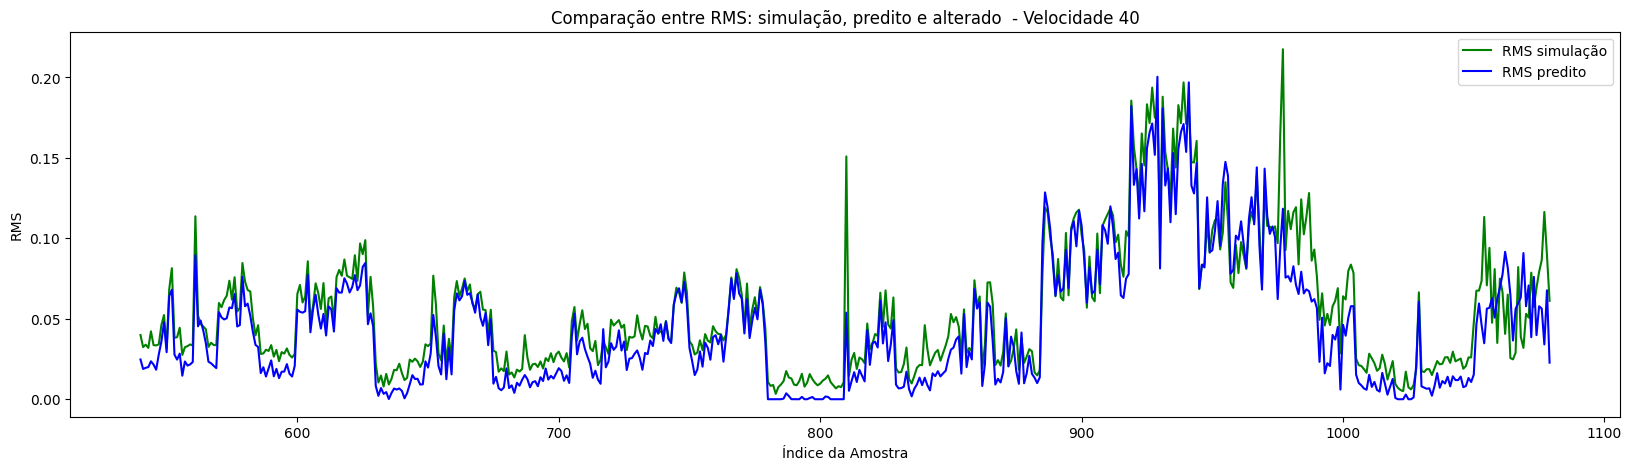

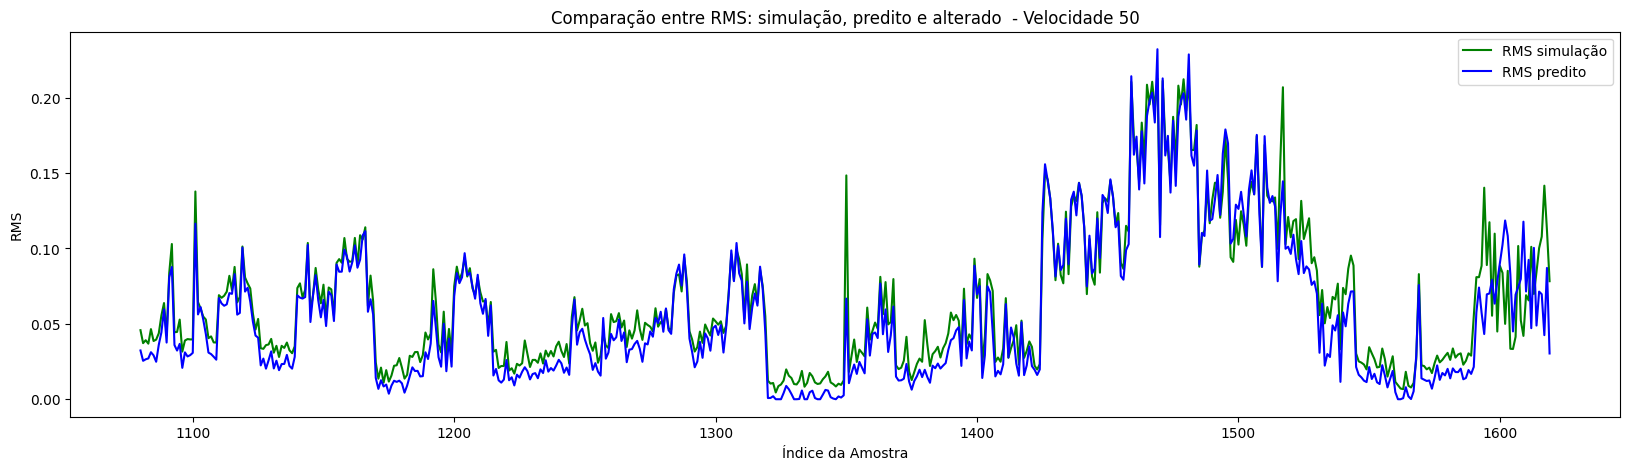

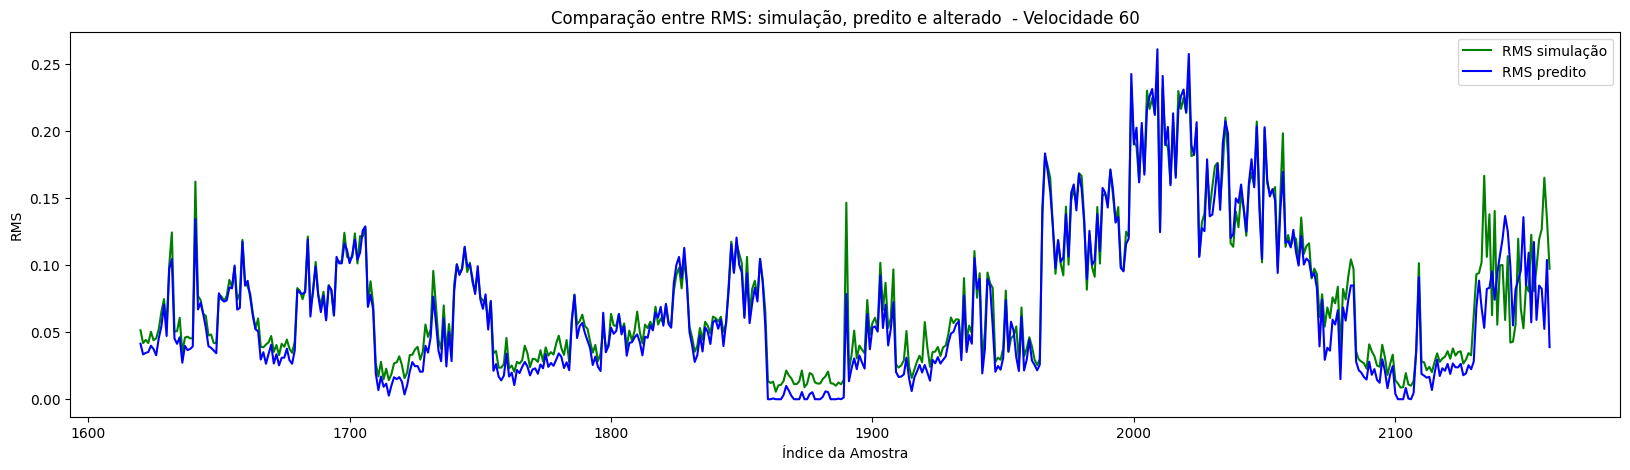

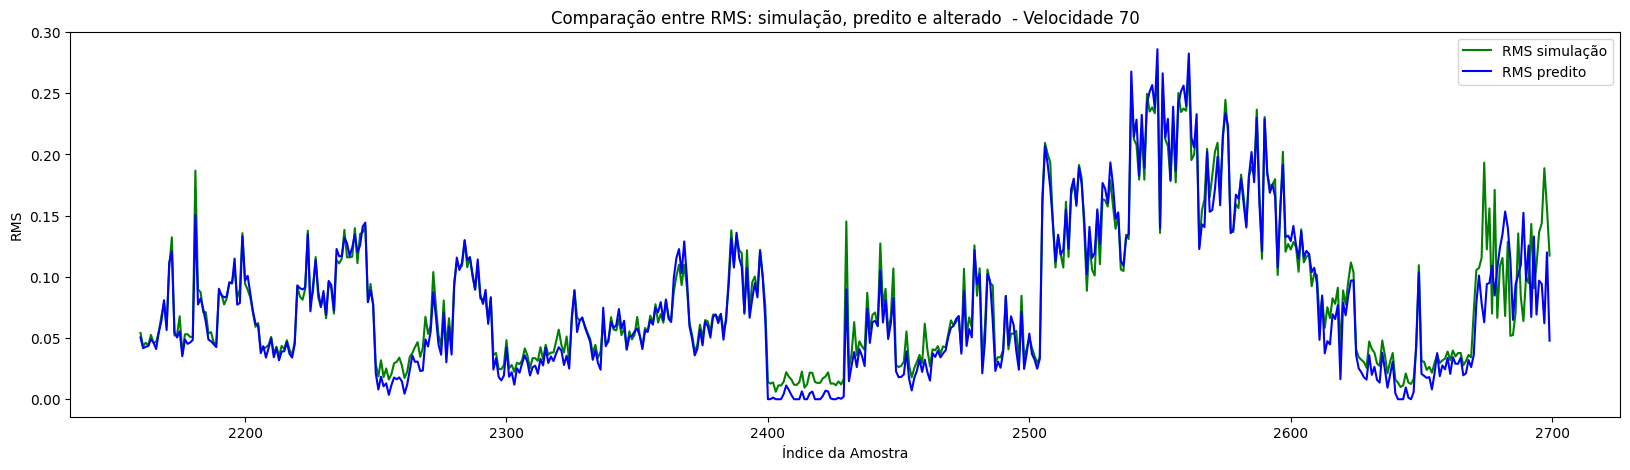

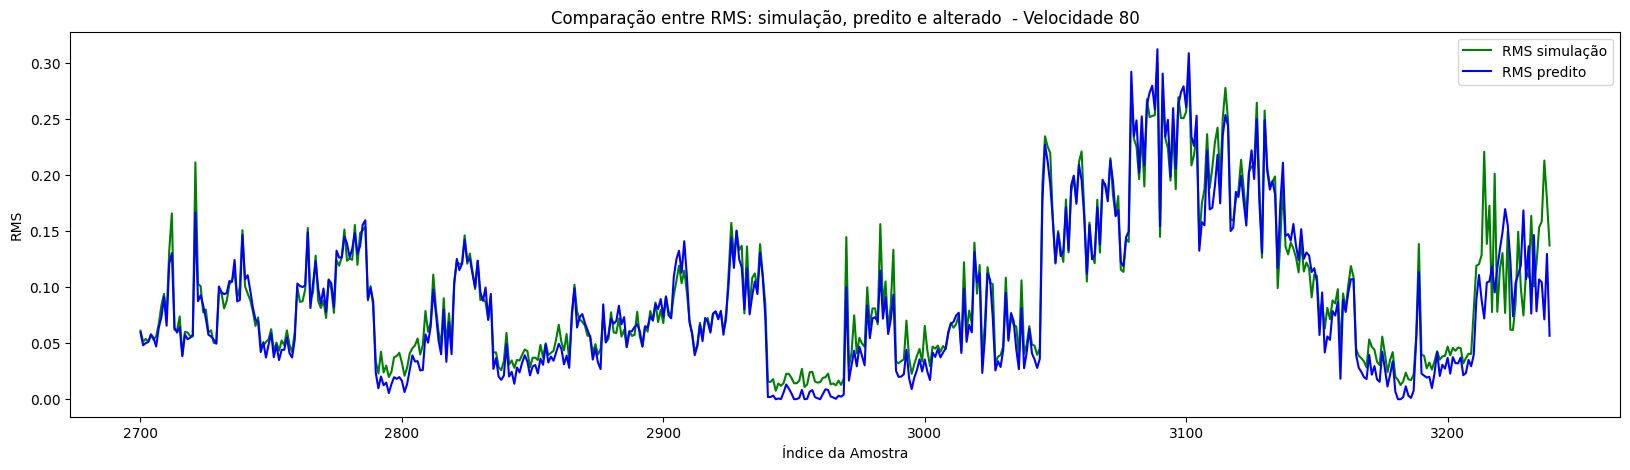

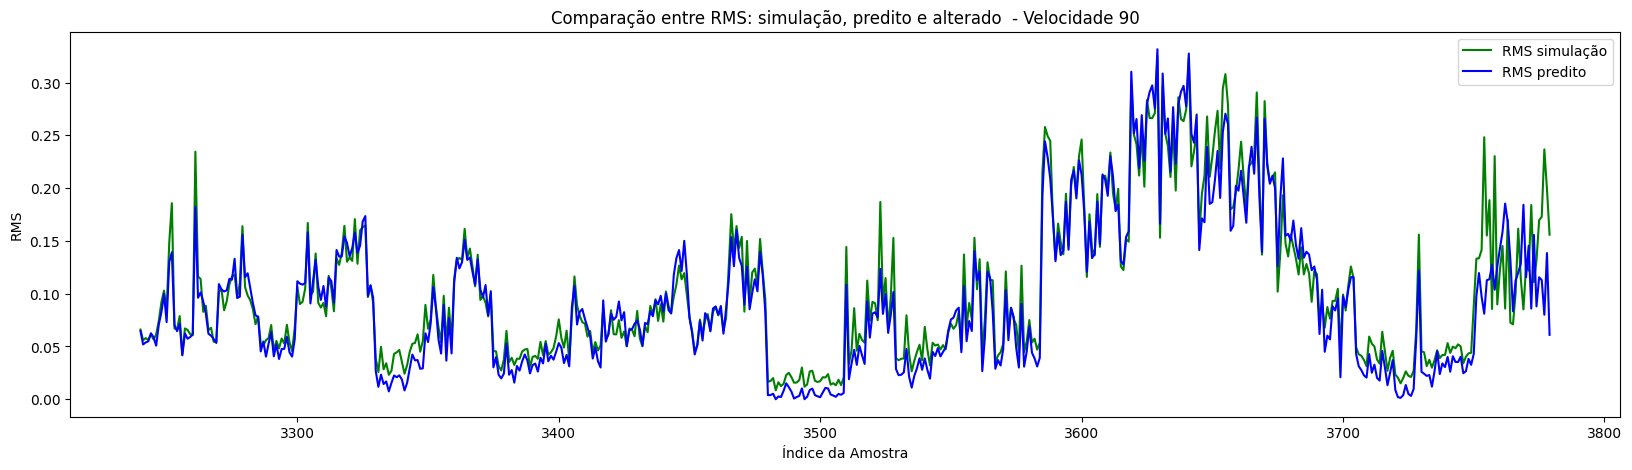

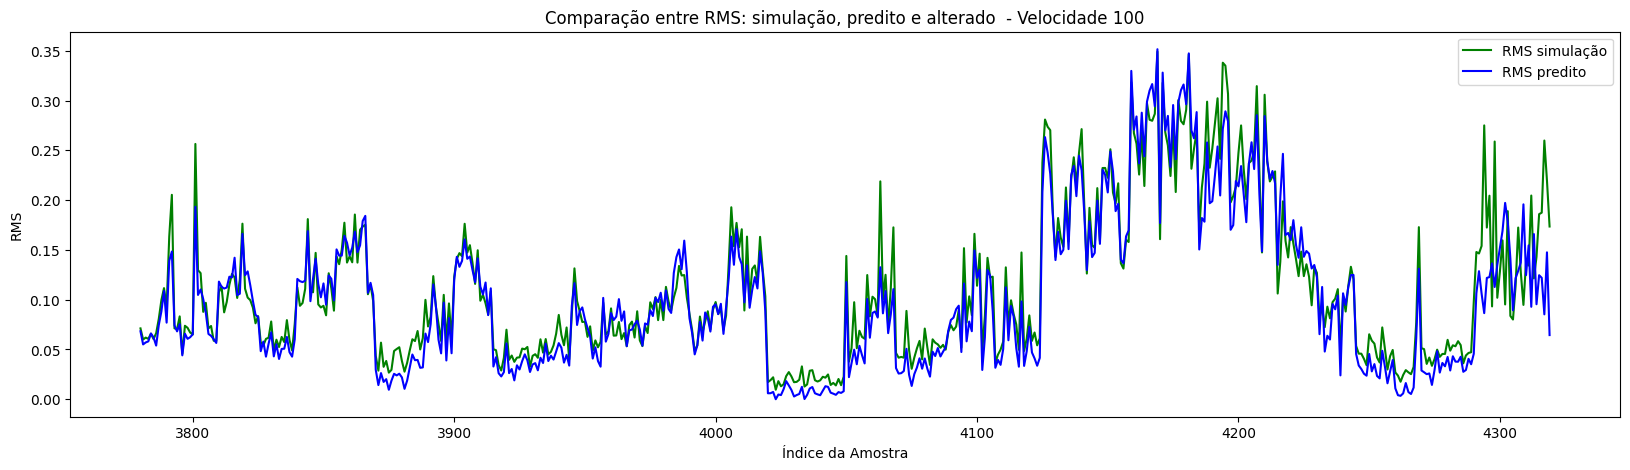

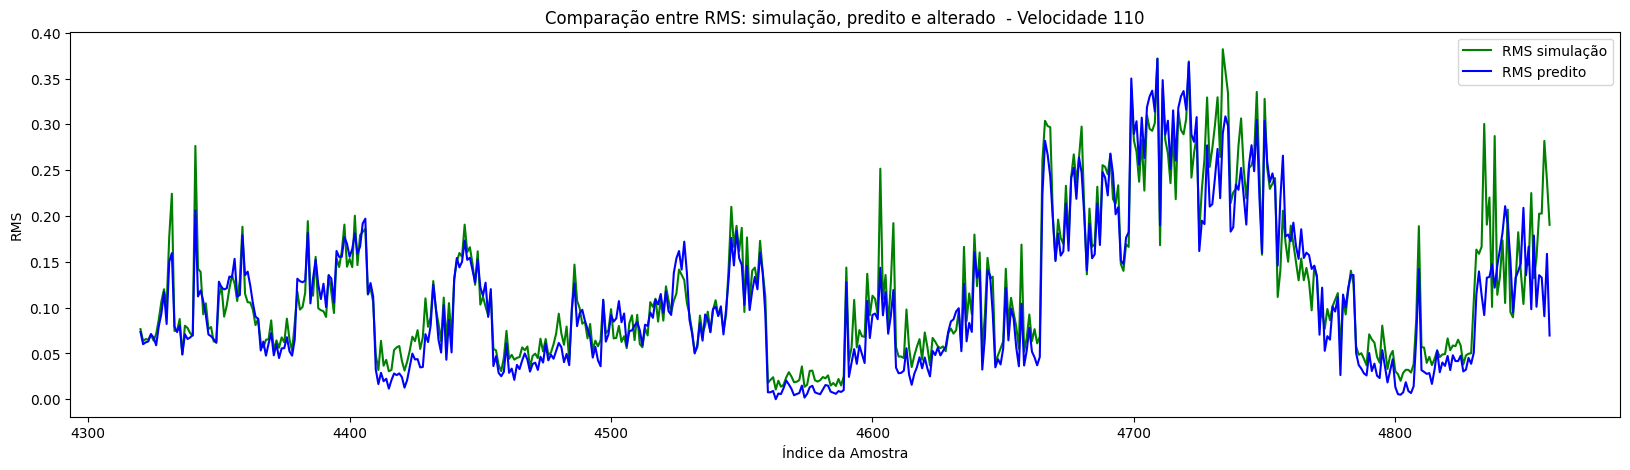

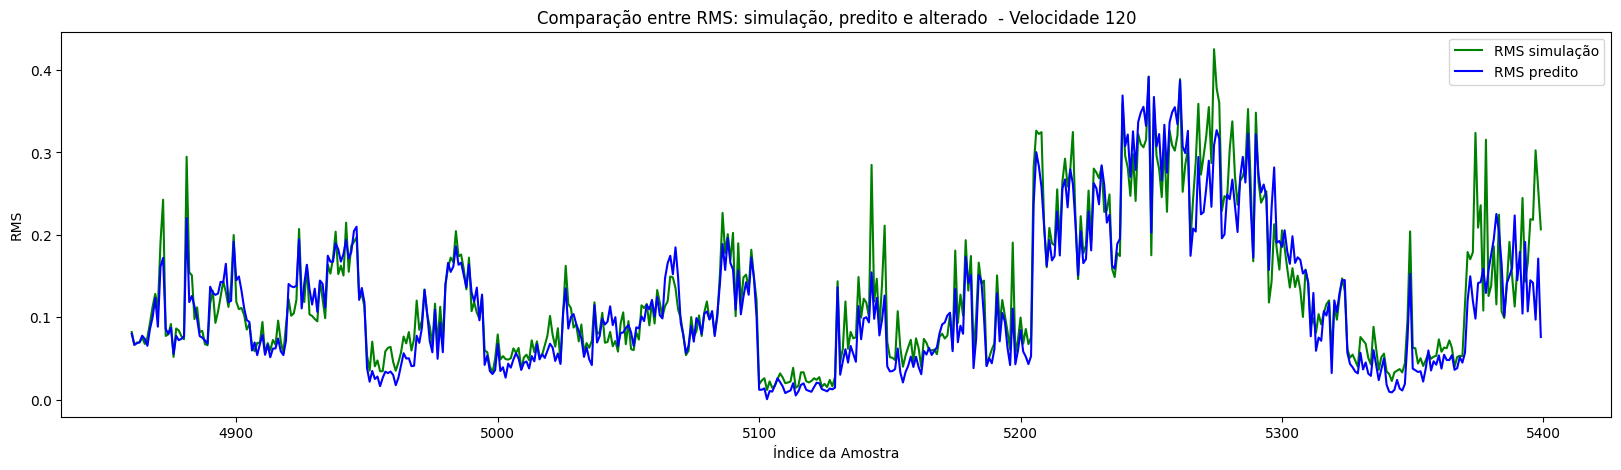

In [99]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_C_HB[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_C_HB[inicio:fim], label='RMS predito', color='blue')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

### D-SDN

In [21]:
y_D_SDN = df_D_SDN.iloc[:, 0]

X_D_SDN = df_D_SDN.iloc[:, 1:12]

y_pred_D_SDN = modelo.predict(X_D_SDN)

169/169 [==============================] - 0s 3ms/step


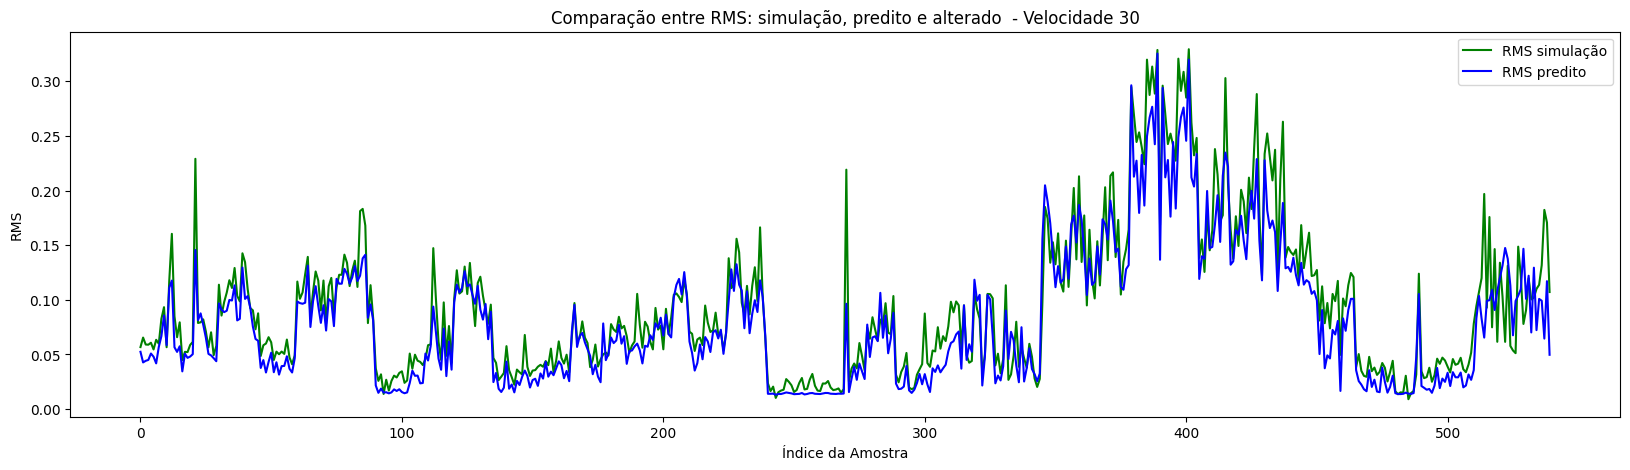

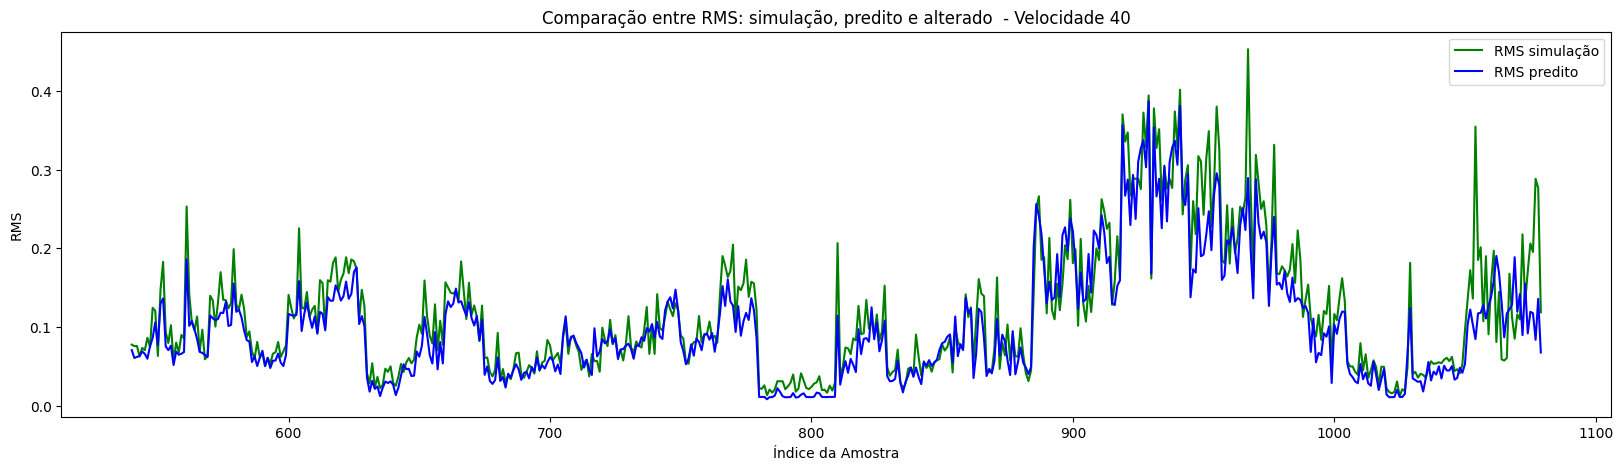

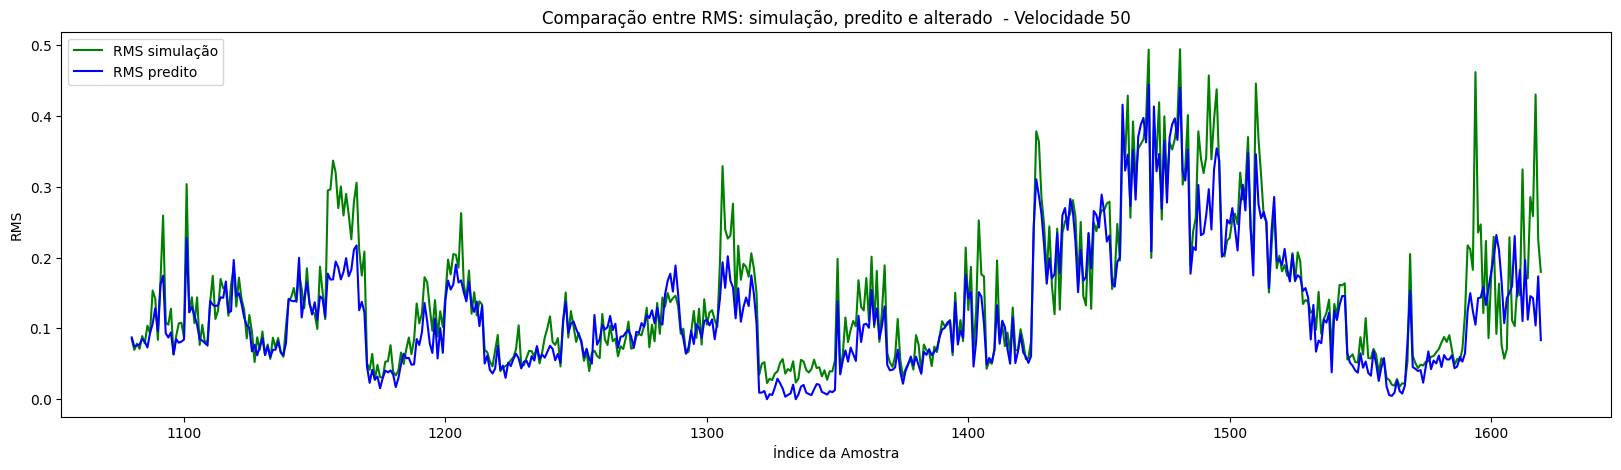

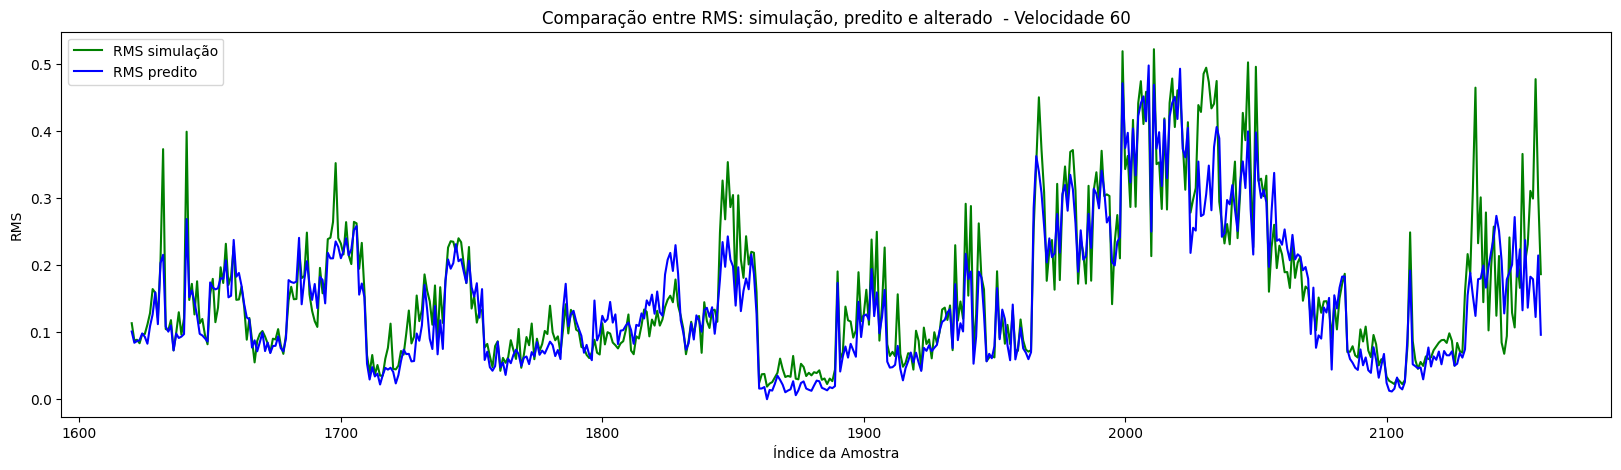

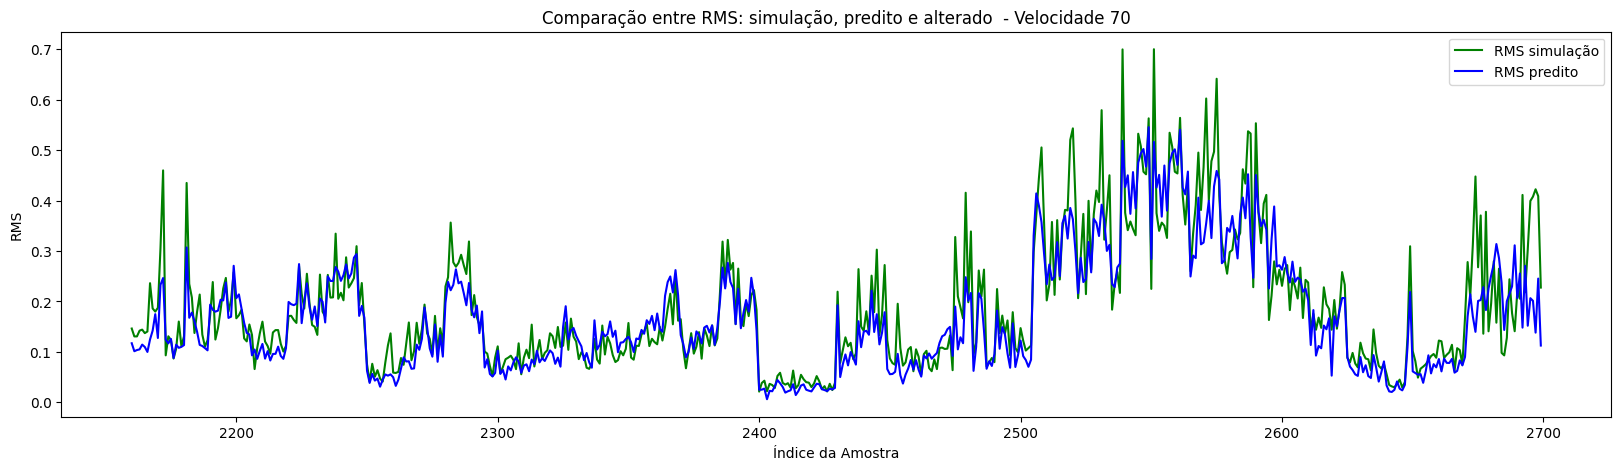

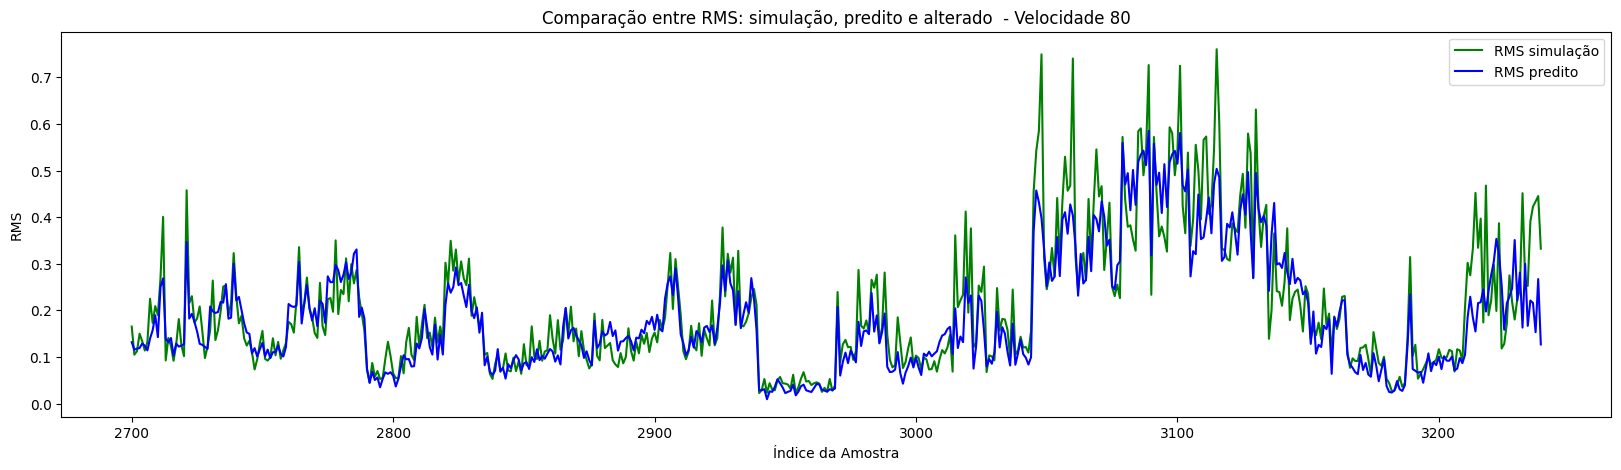

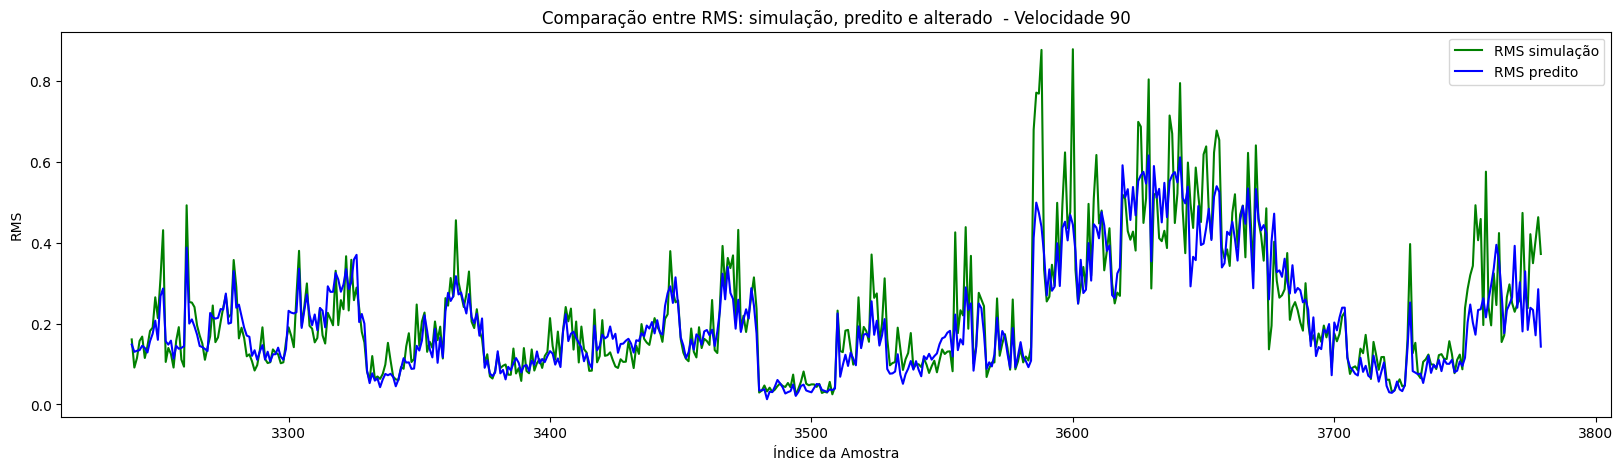

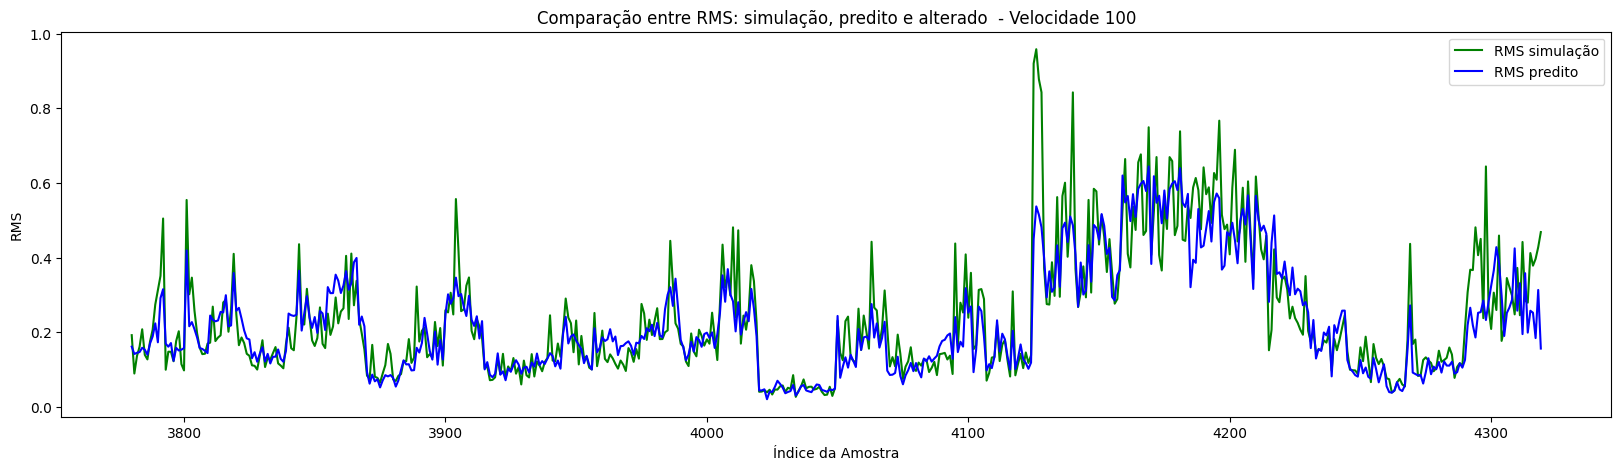

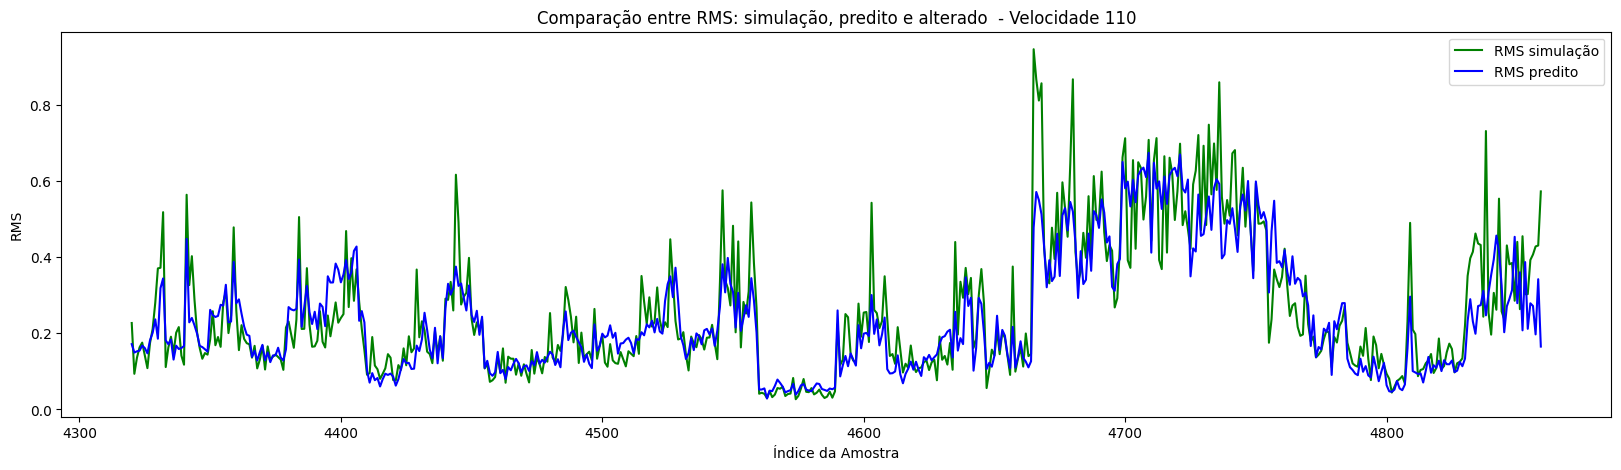

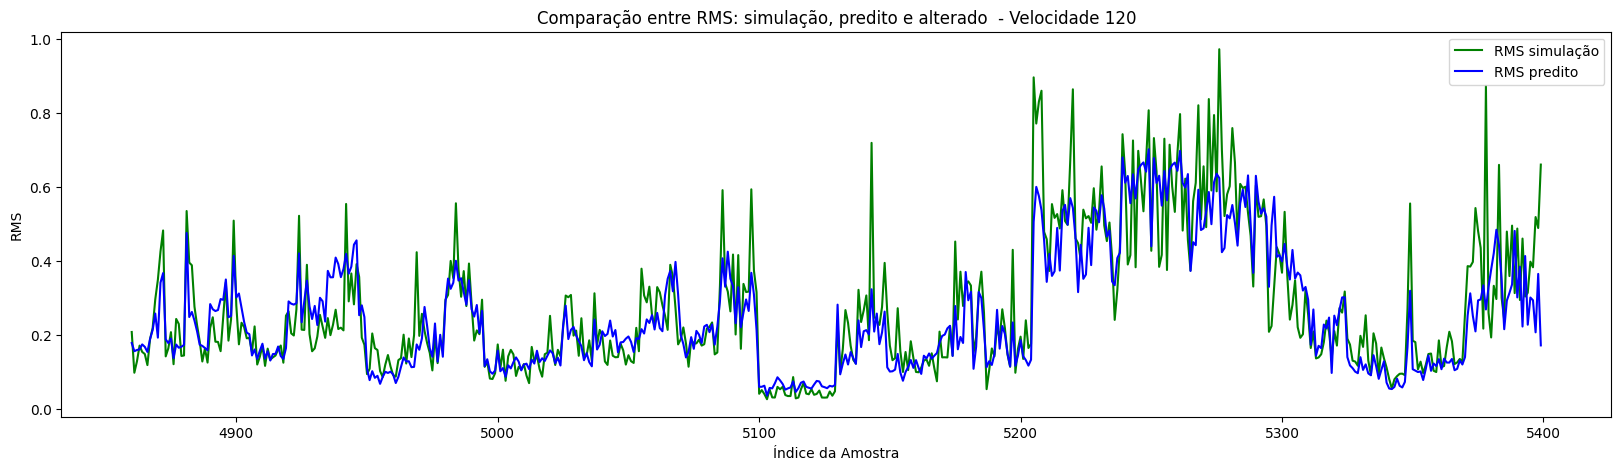

In [22]:
intervalo_total = 5400

num_subdivisoes = 10

tamanho_subdivisao = intervalo_total // num_subdivisoes

for i in range(num_subdivisoes):
    plt.figure(figsize=(20, 5))

    velocidade = 30 + i * 10

    inicio = i * tamanho_subdivisao
    fim = (i + 1) * tamanho_subdivisao

    plt.plot(range(inicio, fim), y_D_SDN[inicio:fim], label='RMS simulação', color='green')
    plt.plot(range(inicio, fim), y_pred_D_SDN[inicio:fim], label='RMS predito', color='blue')
    plt.legend()
    plt.xlabel('Índice da Amostra')
    plt.ylabel('RMS')
    plt.title(f'Comparação entre RMS: simulação, predito e alterado  - Velocidade {velocidade}')
    plt.show()
    print('\n')

### F-SDN

#SHAP

In [81]:
# Crie um masker para a RNA
masker = shap.maskers.Independent(data=X)

# Crie um explainer para a RNA com o masker
explainer_rna = shap.ExactExplainer(modelo, masker=masker)

# Obtenha os valores SHAP para um conjunto de teste diretamente do explainer
shap_values_rna = explainer_rna(X)

AttributeError: Exception encountered when calling layer 'sequential_4' (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received by layer 'sequential_4' (type Sequential):
  • inputs=            IRI         V         k         c        ms       mus       kus
0      0.242190  1.000000  0.635643  0.713457  0.490579  0.504705  0.566038
1      0.204573  1.000000  0.638287  0.411950  0.269139  0.306587  0.566038
2      0.472282  1.000000  0.159704  0.713457  0.702274  0.405646  0.566038
3      0.551517  1.000000  0.096245  0.411950  0.318408  0.306587  0.566038
4      0.012447  0.777778  0.635643  0.713457  0.490579  0.504705  0.566038
...         ...       ...       ...       ...       ...       ...       ...
12795  0.175070  0.555556  0.090957  0.411950  0.406659  0.415552  0.553459
12796  0.175070  0.333333  0.638287  0.411950  0.269139  0.306587  0.566038
12797  0.175070  0.555556  0.387097  0.411950  0.703898  0.702823  0.566038
12798  0.175070  0.555556  0.096245  0.411950  0.318408  0.306587  0.566038
12799  0.175070  0.444444  0.096245  0.411950  0.318408  0.306587  0.566038

[11590 rows x 7 columns]
  • training=None
  • mask=None

['IRI', 'V', 'k', 'c', 'ms', 'mus', 'kus']


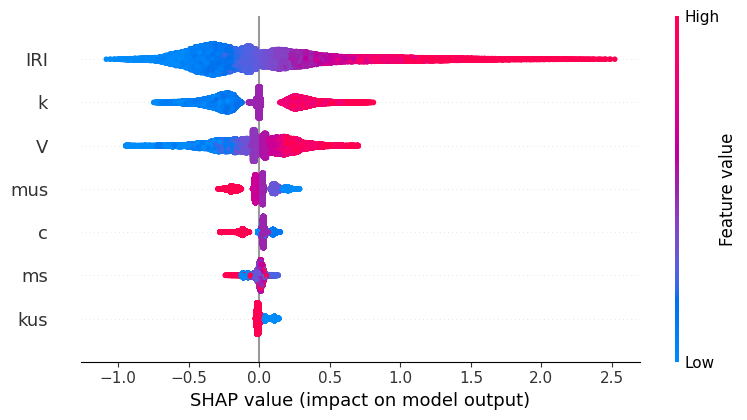

In [ ]:
nomes_primeiras_colunas = df.columns[1:8].tolist()
print(nomes_primeiras_colunas)

shap.summary_plot(shap_values_rna, X, feature_names=nomes_primeiras_colunas)